# Baseball Pitch Outcome prediction Model

Pranith Lomada, Michael Algarra and Mitchell Mullock

### Background and Data Source information:
- We used a python library, pybaseball, to facilitate pulling baseball data from statcast a reliable source of baseball data for the MLB (Major League Baseball).
- Statcast provides multiple forms of data, from season level/game level/pitch level statistics about players, teams, innnings.
- We specifically chose to pull two forms of data...
  1. Pitch level statistics from the 2022 season. In other words, we looked at every pitch thrown by every pitcher on every team in the MLB in 2022.
  2. Aggregated Season level statistics about pitchers and batters to get an estimation player's ability and behavioral tendencies.
- All of this data was pullsed and stored in the form of a psudo-preprocessed csv. Each record in the csv started out as a single pitch and its outcome in the season. Along with this information, we have pre-processed the csv to add pitcher/batter aggregate data relavant to the pitcher/batter the record pertains to.


### Goal: Based on information about the initial pitch, predict the outcome of the at bat event.
- The goal is to take data about the initial pitch at the pitcher's mound and predict what happens when the pitch is released, and the batter has an opportunity to swing/no swing/swing and miss, and so on.


# Initial Setup

In [ ]:
# import and pip install pybaseball related packages
! pip install -q pybaseball
import pybaseball
import requests
from urllib3.exceptions import InsecureRequestWarning
# Suppress the warnings from urllib3
requests.packages.urllib3.disable_warnings(category=InsecureRequestWarning)

# import data handling packages
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
from matplotlib import cm
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 31.2 MB/s eta 0:00:00


# Data Collection Process
For our data collection, we utilized the data scraping python package called pybaseball. Pybaseball's source code can be found here<br> <br>
https://github.com/jldbc/pybaseball <br><br>
Pybaseball is a package that web scrapes from popular public online databases for baseball statistics and creates pandas dataframes for Data Scientists and Baseball Analysts to overview. We are going to utilize the following functions to acquire data:<br>

- <b>batting_stats</b>: To acquire the year statistics of all batters in the 2022 MLB regular season.
- <b>pitching_stats</b>: To acquire the pitching statistics of all pitchers in the 2022 MLB regular season.
- <b>statcast_batter</b>: To acquire all the game data for each batter throughout the 2022 season.
- <b>playerid_reverse_lookup</b>: This helps with data merging and acquiring names with player id's


In [ ]:
# to acquire all batters for the 2022 season and their associated mlbam id / player name
batting_data = pybaseball.batting_stats(2022)
player_fangraphs_id = list(np.unique(batting_data["IDfg"]))
players_2022 = pybaseball.playerid_reverse_lookup(player_fangraphs_id,key_type='fangraphs')[["name_first","name_last","key_mlbam"]]

#### Next is to acquire all pitch data for each batter that was acquired from the 2022 batting data
The following code block takes approximately 40-50 minutes to compile. This is due the magnitude of the data being pulled (Almost 300k rows being web scraped).

In [ ]:
# NOTE: this takes ~ 40 - 50 minutes to run. For time saving purposes we load all this info below
all_game_data = pd.DataFrame()
for row, playerinfo in players_2022.iterrows():
    game_data = pybaseball.statcast_batter('2022-04-01', '2022-10-01',playerinfo["key_mlbam"])
    all_game_data = pd.concat([all_game_data, game_data], ignore_index=True)

In Pybaseball there are multiple different player id's, since it compiles data from different sources / websites. The annual statistics for each player is associated with their fangraphs ID (key_fangraphs) whilst the statcast (every pitch) data is associated with their MLBAM ID. The following code is to use the pitcher and batter MLBAM id from each unique batter and pitcher to acquire the fangraphs id.

In [ ]:
# to acquire the pitcher data with relavent information about information about player performance.
pitching_stats = pybaseball.pitching_stats(2022,qual=1)

# acquire the unique batters from the all_game_data dataframe
unique_batters =  list(set(all_game_data["batter"]))
unique_pitchers =  list(set(all_game_data["pitcher"]))

# acquire the player ids for each unique batter to merge dataframes later on
unique_batters_fg_id = pybaseball.playerid_reverse_lookup(unique_batters,key_type='mlbam')[["key_mlbam","key_fangraphs"]]
unique_pitchers_fg_id = pybaseball.playerid_reverse_lookup(unique_pitchers,key_type='mlbam')[["key_mlbam","key_fangraphs"]]

# merge the dataframes with the two id's needed for the full year merge
batter_year_stats = unique_batters_fg_id.merge(batting_data, left_on = "key_fangraphs", right_on = "IDfg").drop("key_fangraphs",axis=1)
pitcher_year_stats = unique_pitchers_fg_id.merge(pitching_stats, left_on = "key_fangraphs", right_on = "IDfg").drop("key_fangraphs",axis=1)

Now that we have like terms with the id's, we have to join the two dataframes and select the associated columns we'd like to include to display the batter and pitchers ability and behavorial tendencies.<br>
We chose the following statistics that are common place to use as a measure of a players ability:
- for Batters:
  - <b>WAR</b>: Wins Above Replacement
  - <b>AVG</b>: Batting Average
  - <b>OBP</b>: On Base Percentage
  - <b>Swing%</b>: The percentage of swings a particular batter takes for each pitch
  - <b>Contact%</b>: The percentage of contact with the ball the batter makes for each swing
- For Pitchers:
  - <b>WAR</b>: Wins Above Replacement
  - <b>ERA</b>: Earned Run Average over 9 innings
  - <b>WHIP</b>: Walks and Hits per innings pitched
  - <b>K/9</b>: Strikeouts over 9 innings
  - <b>BB/9</b>: Walks over 9 innings
  - <b>H/9</b>: Hits over 9 innings
  - <b>Swing%</b>: The percentage of swings batters takes for each pitch
  - <b>Stuff+</b>: A measure of how effective a pitch is based on the characteristics of a pitch, including it's speed, release point, and movement.

In [ ]:
# now merge the batter / pitcher 2022 full year statistics with the full season pitch data
merged_batter_master = all_game_data.merge(batter_year_stats[["key_mlbam","IDfg","WAR","AVG","OBP","Swing%","Contact%"]], left_on = "batter", right_on = "key_mlbam",suffixes=('', '_batter'))
df_players = merged_batter_master.merge(pitcher_year_stats[["key_mlbam","IDfg","WAR","ERA", "WHIP",'K/9', 'BB/9', "H/9","Swing%","Stuff+"]], left_on = "pitcher", right_on = "key_mlbam",suffixes=('', '_pitcher'))


###*To save time and resources, we have pre compiled all this data into a csv file. We will be using this to conduct our analyses.*

In [ ]:
# Run this cell to mount your drive (you will be prompted to sign in)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_players = pd.read_csv('/content/drive/My Drive/CIS545_Files/2022 Batting Data/2022_merged_data.csv')

# Data Exploration

## Initial Data columns and some context

Initially there were over 100 columns of data. Based on some domain knowledge and research, the list had been narrowed down substantially. For example, all columns that were not relavant to pitching and batting performance, ability, or decision making were removed.

| column name | description |
| ----- | ----- |
| pitch_type | type of pitch thrown (pre-classified by stat cast) in 16 types
| release_speed | speed of ball when released
| release_pos_x | left/right position of ball when released  
| release_pos_z | height of ball when released
| events | outcome (pre-classified by statcast) into 29 events
| description | alternate identification of pitch outcome (pre-classified into 13 events)
| spin_dir | direction of spin of pitch  
| zone | the official strike zone where the ball crosses home plate  
| stand | batter stance (left/right)
| p_throws | pitcher throwing hand (right/left)
| bb_type | batted ball type
| balls | number of balls before the pitch  
| strikes | number of strikes before the pitch  
| pfx_x | movement of the pitch in the x plane
| pfx_z | movement of the pitch in the z plane
| plate_x | x position of the ball when over home plate (horizontal)
| plate_z | x position of the ball when over home plate (vertical)
| on_3b | id of player on 3rd base
| on_2b | id of player on 2nd base  
| on_1b | id of player on 1st base  
| outs_when_up | number of outs in the inning before the pitch
| hc_x | hit coordinate of batted ball in x plane
| hc_y | hit coordinate of batted ball in z plane
| vx0 | initial velocity in x direction
| vy0 | initial velocity in y direction
| vz0 | initial velocity in z direction
| ax | initial acceleration in x direction
| ay | initial acceleration in y direction
| az | initial acceleration in z direction
| sz_top | top of the strikezone
| sz_bot | bottom of the strikezone


In [ ]:
df_abs = df_players[['release_speed', 'release_pos_x', 'release_pos_z', 'description', 'stand', 'p_throws',
                             'balls', 'strikes', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'release_spin_rate', 'effective_speed', 'pitch_name', 'zone', 'spin_axis',
                             'pitch_number','sz_top', 'sz_bot', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_extension', 'inning', 'outs_when_up', 'on_1b', 'on_2b', 'on_3b', 'bat_score', 'fld_score']]

df_abs.head(5).columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'description',
       'stand', 'p_throws', 'balls', 'strikes', 'pfx_x', 'pfx_z', 'plate_x',
       'plate_z', 'release_spin_rate', 'effective_speed', 'pitch_name', 'zone',
       'spin_axis', 'pitch_number', 'sz_top', 'sz_bot', 'vx0', 'vy0', 'vz0',
       'ax', 'ay', 'az', 'release_extension', 'inning', 'outs_when_up',
       'on_1b', 'on_2b', 'on_3b', 'bat_score', 'fld_score'],
      dtype='object')

## Exploring Outcomes

To explore these outcomes, we'll break down the dataframe into each description and their corresponding frequency.

In [ ]:
df_outcomes_explore = df_abs[['description', 'release_speed']].groupby('description', as_index=False).count().rename(columns={'release_speed': 'freq'}).sort_values('freq', ascending=True).reset_index()
df_outcomes_explore

,index,description,freq
0,2,bunt_foul_tip,4
1,10,pitchout,24
2,9,missed_bunt,50
3,5,foul_bunt,264
4,7,hit_by_pitch,871
5,12,swinging_strike_blocked,1632
6,6,foul_tip,2777
7,1,blocked_ball,6898
8,11,swinging_strike,28798
9,3,called_strike,48354


Observations:
<ul>
  <li>We see that not all outcomes occur at the same frequency. <b>This could lead to a bias in the model</b></li>
  <li>Although not stated out right, a foul, and foul tip are marked as two different outcomes however they are both fouls.</li>
  <li>It is best to group the outcomes to better suit our model for both frequency and our general goal of prediction. </li>
</ul>

# Cleaning Data  

## Initial Visualizations


### Comparing individual pitchers

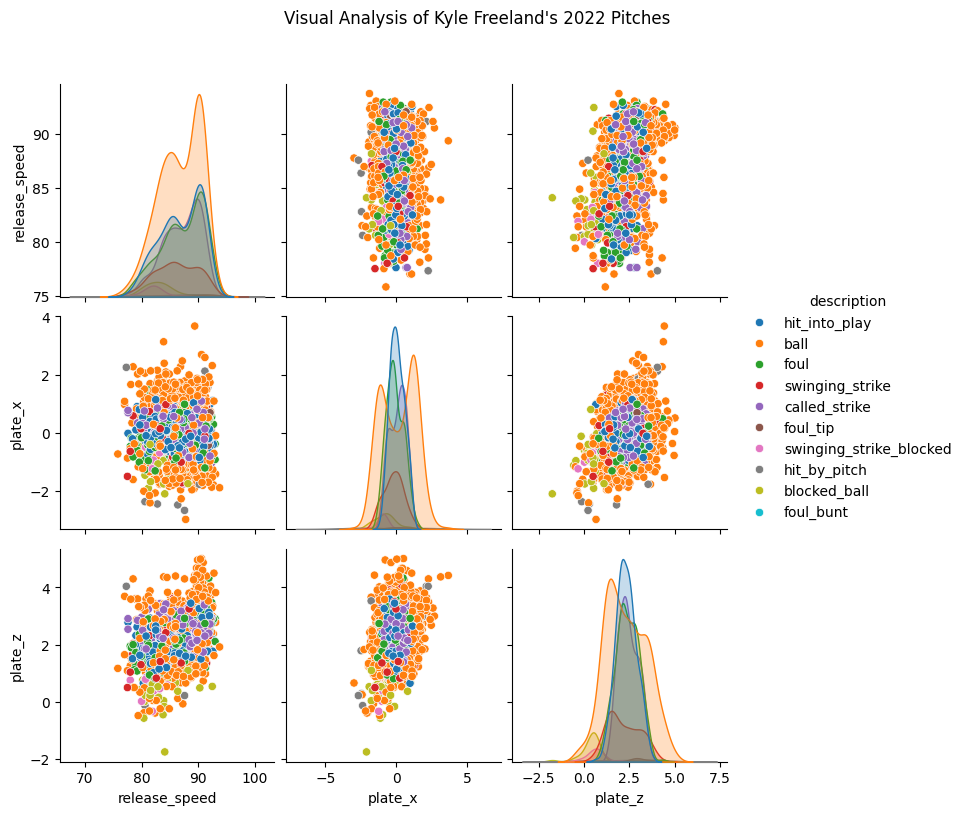

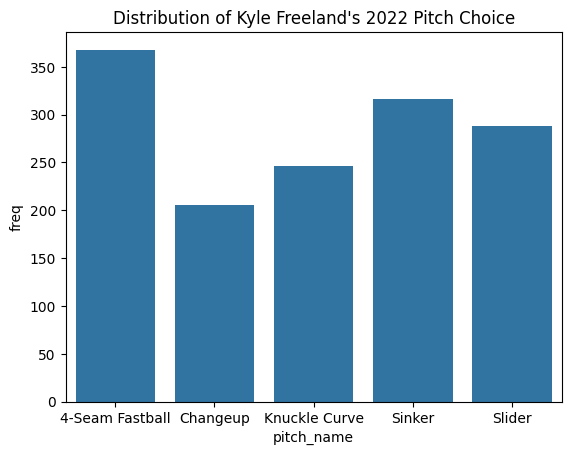

In [ ]:

visual_df = df_players[df_players['description'].isna() == False].copy()


# other useful columns for features could be: 'balls', 'strikes', 'zone', 'events', 'type', 'bb_type', 'strikes', 'balls'
#testing_df = testing_df[['pitch_type', 'release_speed', 'plate_x', 'plate_z', 'events', 'type', 'bb_type']]
testing_df = visual_df[visual_df['pitcher'].isin([607536])]
g = sns.pairplot(testing_df[['description', 'release_speed', 'plate_x', 'plate_z']], hue='description', dropna=True)
g.fig.suptitle("Visual Analysis of Kyle Freeland's 2022 Pitches", y=1.08)

something = plt.show()

testing_df_2 = df_players[df_players['pitcher'].isin([607536])]
testing_df_2 = testing_df_2[['pitch_name', 'release_speed']].groupby('pitch_name', as_index=False).count().rename(columns={'release_speed': 'freq'})
plotObj = sns.barplot(testing_df_2, x='pitch_name', y = 'freq').set_title("Distribution of Kyle Freeland's 2022 Pitch Choice")

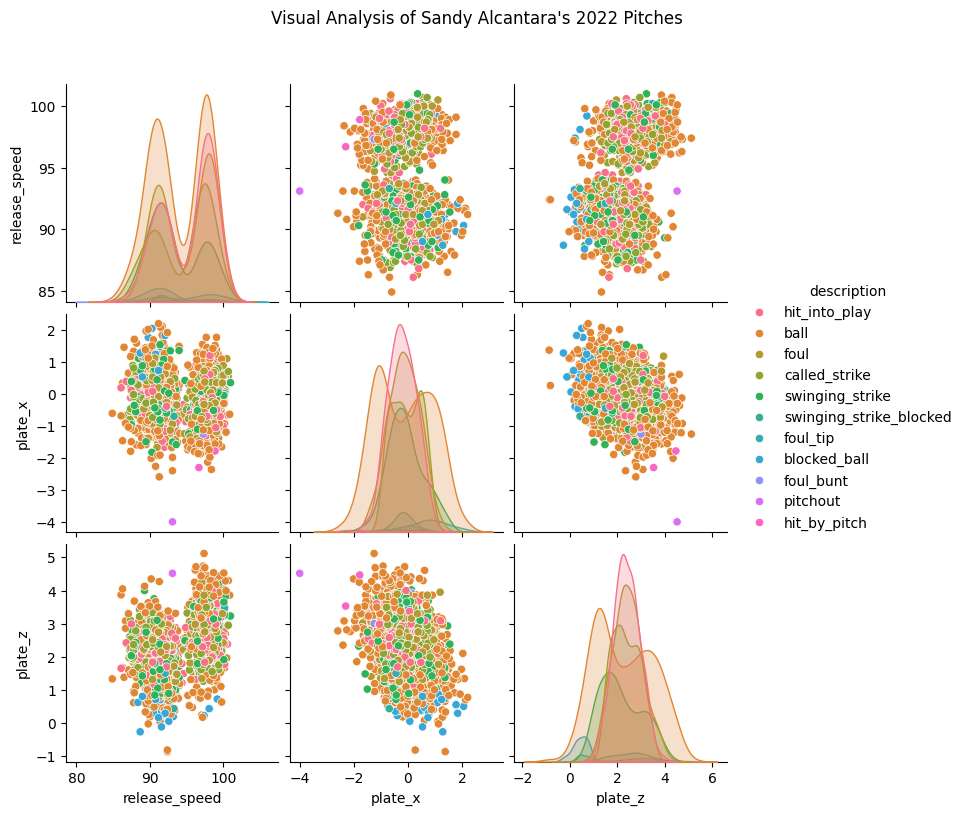

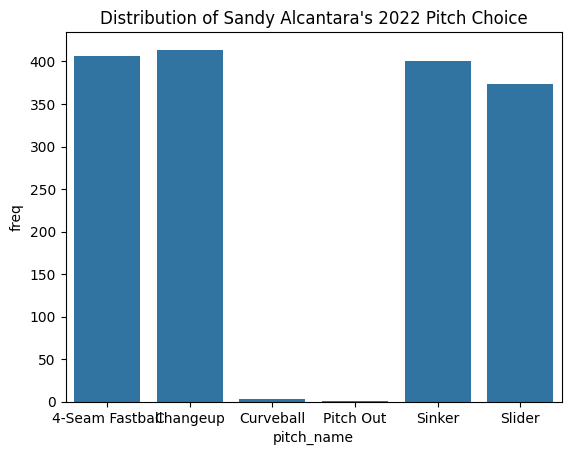

In [ ]:

visual_df = df_players[df_players['description'].isna() == False].copy()


# other useful columns for features could be: 'balls', 'strikes', 'zone', 'events', 'type', 'bb_type', 'strikes', 'balls'
#testing_df = testing_df[['pitch_type', 'release_speed', 'plate_x', 'plate_z', 'events', 'type', 'bb_type']]
testing_df = visual_df[visual_df['pitcher'].isin([645261])]

g = sns.pairplot(testing_df[['description', 'release_speed', 'plate_x', 'plate_z']], hue='description', dropna=True)
g.fig.suptitle("Visual Analysis of Sandy Alcantara's 2022 Pitches", y=1.08)
plt.show()

testing_df = visual_df[visual_df['pitcher'].isin([645261])]

testing_df = testing_df[['pitch_name', 'release_speed']].groupby('pitch_name', as_index=False).count().rename(columns={'release_speed':'freq'})
sns.barplot(testing_df, x='pitch_name', y='freq').set_title("Distribution of Sandy Alcantara's 2022 Pitch Choice")
plt.show()


Conclusion:

Some observations:

We compared two players with the most most number of pitches and here is what we notice...
<ul>
  <li>There are some clear distinctions that can be drawn when comparing the speed, positioning, and outcome of pitches when comparing two players </li>
  <li> Each pitcher is likely to have different tendencies and different perforamnce for a given pitch and under given circumstances</li>
</ul>

This becomes more obvious when we compare the choices that pitchers choose when looking at the choices made based pitch distribution.

In order to caputre the difference in players and their competance, we have included additional values about players (both pitchers and batters) to describe their general ability.

## Encoding Categorical Variables

Since we building a classifier where there are multiple labels, this is a 1 vs rest type modeling. The unique labels will be mapped to unique integers.

stand and p_throws which represent the batter and pitcher's handedness will be mapped as well since they are either right handed or not. There are only two possible values.

Pitch Name consists of several values, we want to give the model an oppertunity to use each of the various pitch types as sepearte inputs so they will be one-hot encoded. Also, we have seen from various tests where we compared one-hot encoding vs mapping, the model performs better when one-hot encoded. There is likely some coorelation between indiviual pitch types and other features in the data set.

In [ ]:
## other categorical variables include on_b1, on_b2, and on_b3
categoricalColumnNameList = ['description', 'stand', 'p_throws', 'pitch_name']

for columnName in categoricalColumnNameList:
  print('columnName: %s' % (columnName))
  print(df_abs[columnName].unique())

columnName: description
['hit_into_play' 'ball' 'foul' 'called_strike' 'swinging_strike'
 'blocked_ball' 'hit_by_pitch' 'swinging_strike_blocked' 'foul_tip'
 'foul_bunt' 'missed_bunt' 'pitchout' 'bunt_foul_tip']
columnName: stand
['L' 'R']
columnName: p_throws
['R' 'L']
columnName: pitch_name
['Slider' '4-Seam Fastball' 'Curveball' 'Changeup' 'Sinker' nan 'Cutter'
 'Sweeper' 'Knuckle Curve' 'Split-Finger' 'Pitch Out' 'Slurve' 'Eephus'
 'Other' 'Slow Curve' 'Knuckleball']


In [ ]:
## mapping description column to an integer value for encoding
description_map = {'hit_into_play' : 0, 'ball' : 1, 'foul' : 2, 'called_strike' : 3, 'swinging_strike' : 4, 'foul_tip' : 5, 'blocked_ball' : 6, 'swinging_strike_blocked' : 7,
                   'hit_by_pitch' : 8, 'foul_bunt' : 9, 'missed_bunt' : 10, 'pitchout' : 11, 'bunt_foul_tip' : 12}

df_abs['desc_mapped'] = df_abs['description'].apply(lambda x: description_map[x])


<ipython-input-9-27143da57d90>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_abs['desc_mapped'] = df_abs['description'].apply(lambda x: description_map[x])


In [ ]:
## on_1b is the player id of the player on first base and so on for 2b and 3b or NA if no player is on that base.
## We know that from watching baseball that pitch selection will vary depending on how the bases are loaded.
## We will encode this information by converting all NA's to 0 and all playerIds to 1.
df_abs[['on_1b', 'on_2b', 'on_3b']].fillna(0)
df_abs['first'] = df_abs['on_1b'].apply(lambda x: 1 if x > 0 else 0)
df_abs['second'] = df_abs['on_2b'].apply(lambda x: 1 if x > 0 else 0)
df_abs['third'] = df_abs['on_3b'].apply(lambda x: 1 if x > 0 else 0)

df_abs = df_abs.drop(columns=['on_1b', 'on_2b', 'on_3b'], axis=1)

<ipython-input-10-88ffa245c016>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_abs['first'] = df_abs['on_1b'].apply(lambda x: 1 if x > 0 else 0)
<ipython-input-10-88ffa245c016>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_abs['second'] = df_abs['on_2b'].apply(lambda x: 1 if x > 0 else 0)
<ipython-input-10-88ffa245c016>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [ ]:
## stand refers to the handedness of the batter's stance and p_throws refers to the handedness of the pitch
## These will be converted to binary values where 'R' is converted to 1 and 'L' is converted to 0
df_abs['b_hits'] = df_abs['stand'].apply(lambda x: 1 if x == 'R' else 0)
df_abs['p_pitches'] = df_abs['p_throws'].apply(lambda x: 1 if x == 'R' else 0)

df_abs = df_abs.drop(columns=['stand', 'p_throws'], axis=1)

In [ ]:
## we will repeat the encoding process for pitch type

# mapping pitch_Type, dropping rows where pitch_type is na, and applying mapping
pitch_type_mapping = {'Slider' : 0, '4-Seam Fastball' : 1, 'Curveball' : 2, 'Changeup' : 3, 'Sinker': 4,
        'Cutter': 5, 'Sweeper' : 6, 'Knuckle Curve' : 7, 'Split-Finger': 8, 'Eephus' : 9, 'Slurve' : 10,
        'Other' : 11, 'Knuckleball' : 12, 'Pitch Out' : 13, 'Slow Curve': 14}

df_abs = df_abs[df_abs['pitch_name'].isna() != True]
df_abs['pitch_type'] = df_abs['pitch_name'].apply(lambda x: int(pitch_type_mapping[x]))


## this will be used for actual analysis
encoded_df_abs = pd.get_dummies(df_abs, columns=['pitch_name'])
encoded_df_abs = encoded_df_abs.drop('description', axis=1)
encoded_df_abs = encoded_df_abs.dropna(axis=1)

df_abs = df_abs.drop(['pitch_name', 'description'], axis=1)


<ipython-input-12-bf4b2a355ea6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_abs['pitch_type'] = df_abs['pitch_name'].apply(lambda x: int(pitch_type_mapping[x]))


## Visualizing feature set for coorelation

Now that the data has been encoded, we need to take a look at any general trends between various features and other features AND features and the label.

There are a large number of features. This gives us a first look at what features are unnecessary or provide little value. Those will be features that can be removed later in the analysis.

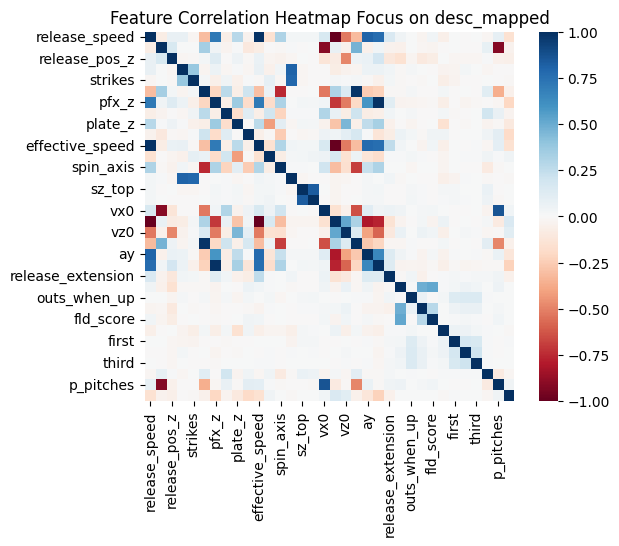

<Figure size 30000x30000 with 0 Axes>

In [ ]:
corr_mat = df_abs.corr()

# TO-DO: Plot correlation heatmap (3 points)
axis = plt.axes()
axis.set_title('Feature Correlation Heatmap Focus on desc_mapped')
sns.heatmap(corr_mat, vmin=-1, vmax= 1,center= 0, cmap='RdBu', square=True)

s = plt.figure()
s.set_figwidth(300)
s.set_figheight(300)

plt.show()

In [ ]:
## Now looking at the comparison of all input features vs label we see the following coorelations
print(corr_mat.sort_values('desc_mapped')['desc_mapped'])

plate_z             -0.150288
pfx_z               -0.070238
strikes             -0.064108
az                  -0.061797
vz0                 -0.057839
release_speed       -0.057135
pitch_number        -0.055969
effective_speed     -0.055673
ay                  -0.039926
balls               -0.032587
spin_axis           -0.031125
zone                -0.027195
pitch_type          -0.009702
release_pos_x       -0.001236
p_pitches            0.000355
bat_score            0.000841
vx0                  0.001151
release_pos_z        0.003910
fld_score            0.004100
inning               0.008295
sz_bot               0.010244
b_hits               0.010578
release_extension    0.015493
sz_top               0.016247
ax                   0.024066
pfx_x                0.024643
outs_when_up         0.024696
third                0.025858
plate_x              0.027305
release_spin_rate    0.043597
second               0.050297
vy0                  0.057841
first                0.058638
desc_mappe

Conclusion

We can gather some general information from the coorelation matrix:
<ul>
  <li>We can see that there the level of coorelation varies from very coorelated/anti-coorelated to not coorelated at all. </li>
  <li> We also see features such as initial velocity in teh x and z direction that overlap with final position over the plate in the x and z direction that might be too coorelated so that one set or the other might need to be removed. </li>
  <li> For this reason, it is necessary to perform PCA to reduce the feature set later in the analysis</li>
</ul>

# Providing a BaseLine for comparison: Initial Guess Model

Seeing that there are x number of outcomes, the inital guess would be to randomly guess outcome and weigh the guesses by the frequency of a given outcome in the data set.

As expected this is a pretty low success model with an accuracy rate of around <b>21.6%</b> over 100 trials.


In [ ]:
import random

df_description_freq = df_players[['description', 'release_speed']].groupby('description', as_index=False).count().rename(columns={'release_speed': 'frequency'})

total_count = df_description_freq['frequency'].sum()


df_guess_model = df_players[['description']].copy()
acc_log = []
for i in range(0, 100):
  # print(i)
  df_guess_model['rand_predict'] = df_guess_model['description'].apply(lambda x: random.choices(df_description_freq['description'], df_description_freq['frequency'], k=1)[0])

  accuracy = df_guess_model[df_guess_model['description'] == df_guess_model['rand_predict']].count()
  acc_log.append( accuracy / total_count)

total_acc = 0
for cur_entry in acc_log:
  total_acc = total_acc + cur_entry['description']

total_acc = total_acc / 100
print('estimated accuracy for random weighted guess: %f' % (total_acc))

estimated accuracy for random weighted guess: 0.216716


# Initial model - Logistic Regression

We want to use Logistic Regression to get a baseline for the quality of a model (as opposed to Random Guess) before we tweak features, outcome set, and try the effectiveness of different models.

### Normalization and Preparation

In [ ]:
from sklearn.preprocessing import StandardScaler

features_abs = encoded_df_abs.drop('desc_mapped', axis=1)
target_abs = encoded_df_abs['desc_mapped']

# split into training and testing datasets
seed = 42
X_train_abs, X_test_abs, y_train_abs, y_test_abs = train_test_split(features_abs, target_abs, test_size= .20, train_size = .80, random_state= seed)

## applying standard scaler to df_players
scaler_abs = StandardScaler()

X_train_scaled_abs = scaler_abs.fit_transform(X_train_abs)
X_test_scaled_abs = scaler_abs.transform(X_test_abs)

X_train_scaled_abs.shape
##NOTE: final data into model: (X_train_scaled_abs, y_train_abs) and (X_test_scaled_abs, y_test_abs)



(238261, 28)

In [ ]:
from sklearn import linear_model

### scaled model training and testing
model_scaled = linear_model.LogisticRegression(max_iter=16000)
model_scaled.fit(X_train_scaled_abs, y_train_abs)

y_scaled_pred = model_scaled.predict(X_test_scaled_abs)

log_scaled_acc = model_scaled.score(X_test_scaled_abs, y_test_abs)
print('scaled feature set results (accuracy):', log_scaled_acc)

scaled feature set results (accuracy): 0.3441728502837189


## Results and Conclusion:





The model produced an accuracy of 0.3441.

Model is substantially better than a random guess model. Let's further explorte the data set to see if perforance can be increased.

# Second Iteration - Adjusting Outcomes and features

Let's try to use unsupervised clustering algorithms to do the following:
<ul>
  <li>Find natural clusters and groupings without label knowledge</li>
  <li>Reduce/transform feature set</li>
  <li>Reduce outcome set</li>
</ul>

The general goal of this section is to dive deeper into the data set to see if teaks to our modeling outcome can increase performance.

## Using k-Means to classify the outcomes of a PCA-reduced feature set

Outcomes:
<ul>
  <li>The elbow of the k-Means plot is shown to be at 4 or 5. We categorize our outcomes into a set of size 4 as a result.</li>
</ul>

### Pre-Processing Data

In [ ]:
df_abs = df_players[['release_speed', 'release_pos_x', 'release_pos_z', 'description', 'stand', 'p_throws', 'type',
                             'balls', 'strikes', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'release_spin_rate', 'effective_speed', 'pitch_name', 'zone', 'spin_axis',
                             'pitch_number','sz_top', 'sz_bot', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_extension', 'inning', 'outs_when_up', 'on_1b', 'on_2b', 'on_3b']]

Now we will pre process the data to classify pitch types and pitch results into different pools. After which we will separate the target variable from the other variables.

In [ ]:
# USED FOR DF_ABS
def classify_pitch_type(desc):
  if (desc == '4-Seam Fastball' or desc == 'Cutter' or desc == 'Sinker'):
    return 'fastball'
  elif (desc == 'Curveball' or desc == 'Eephus' or desc == 'Knuckle_Curve'or desc == 'Slider' or desc == 'Slow Curve' or desc =='Slurve' or desc == 'Sweeper'):
    return 'breaking_ball'
  elif (desc == 'Changeup'or desc == 'Split-Finger'):
    # if desc == 'called_strike':
    #   return 'strikeout_looking'
    # return 'strikeout_swinging'
    return 'off_speed'
  elif (desc == 'Pitch Out'):
    return 'pitch_out'
  else:
    return 'other'

# USED FOR DF_ABS more outcomes
def classify_pitch_result(desc):
  if (desc == 'hit_into_play'):
    return 'in_play'
  elif (desc == 'swinging_strike' or desc == 'swinging_strike_blocked' or desc == 'missed_bunt' or desc == 'called_strike'
        or desc == 'foul' or desc == 'foul_bunt' or desc == 'foul_tip' or desc == 'bunt_foul_tip'):
    return 'strike'
  else:
    return 'ball'

# Classify pitch_results into swing_contact, swing_miss, take_strike, take_ball
description_map = {'hit_into_play' : 0, 'ball' : 1, 'foul' : 2, 'called_strike' : 3, 'swinging_strike' : 4, 'foul_tip' : 5, 'blocked_ball' : 6, 'swinging_strike_blocked' : 7,
                   'hit_by_pitch' : 8, 'foul_bunt' : 9, 'missed_bunt' : 10, 'pitchout' : 11, 'bunt_foul_tip' : 12}

df_abs['desc_mapped'] = df_abs['description'].apply(lambda x: description_map[x])

df_abs['b_hits'] = df_abs['stand'].apply(lambda x: 1 if x == 'R' else 0)
df_abs['p_pitches'] = df_abs['p_throws'].apply(lambda x: 1 if x == 'R' else 0)
df_abs = df_abs.drop(['type', 'description', 'stand', 'p_throws', 'on_1b', 'on_2b', 'on_3b'], axis =1)

df_abs = df_abs.dropna()

# Encode Pitch Name & Convert pitch_result to numbered values

encoded_df_abs = pd.get_dummies(df_abs, columns=['pitch_name'])
# encoded_df_abs = encoded_df_abs.drop(columns=['pitch_name'], axis = 1)
# encoded_df_abs = encoded_df_abs.drop(columns=['pitch_type'], axis = 1)          ### LOOK HERE: THIS LINE IS NEW. WITHOUT IT

# OPTIONAL
encoded_df_abs = encoded_df_abs.drop(['release_speed', 'effective_speed', 'ax', 'ay', 'az'], axis=1)


# Split into features and labels

features_abs = encoded_df_abs.drop('desc_mapped', axis = 1)

target_abs = encoded_df_abs['desc_mapped']

# target.head(10)

seed = 42
X_train_abs, X_test_abs, y_train_abs, y_test_abs = train_test_split(features_abs, target_abs, test_size= .20, train_size = .80, random_state= seed)


<ipython-input-8-e54b5a72620b>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_abs['desc_mapped'] = df_abs['description'].apply(lambda x: description_map[x])
<ipython-input-8-e54b5a72620b>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_abs['b_hits'] = df_abs['stand'].apply(lambda x: 1 if x == 'R' else 0)
<ipython-input-8-e54b5a72620b>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [ ]:
# TO-DO: Import necessary libraries
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

Now we will scale our data and run PCA to reduce the datas dimensionality.

In [ ]:
# 1. Refit and transform on training with parameter n (as deduced from the last step)
scaler_abs = StandardScaler()
X_train_scaled_abs = scaler_abs.fit_transform(X_train_abs)
pca_abs = PCA(n_components=20)
pca_abs.fit(X_train_scaled_abs)
X9 = pca_abs.transform(X_train_scaled_abs)
# 2. Transform on Testing Set and store it as `X_test_pca
X_test_s_abs = scaler_abs.transform(X_test_abs)

X_test_pca_abs = pca_abs.transform(X_test_s_abs)

### K-Means Clustering and Elbow Plot

Goal: explore ways to reduce the outcome set

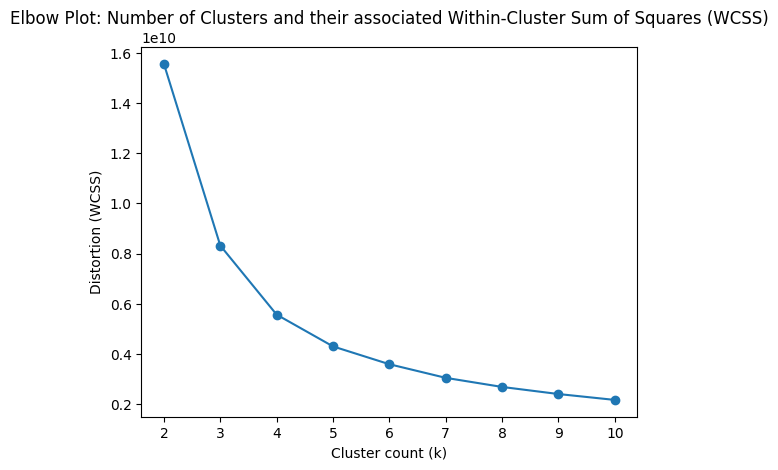

In [ ]:
# Import the necessary libraries
from sklearn.cluster import KMeans

# TO-DO: [MANUALLY GRADED: 4 points]
#   for k ranges from 2 to 10, fit on "features" to generate an elbow plot
lst = []
for i in range(2, 11):
  km = KMeans(n_clusters=i,
              n_init=5,
              random_state=0)
  km.fit(features_abs)
  lst.append(km.inertia_)

plt.plot(range(2, 11), lst, marker='o')
plt.xlabel('Cluster count (k)')
plt.ylabel('Distortion (WCSS)')
plt.title('Elbow Plot: Number of Clusters and their associated Within-Cluster Sum of Squares (WCSS)')
plt.show()

### Interpreting Results from k-Means

It appears the elbow appears at 4 or 5 different outcomes. Let's review the outcome set again to see what makes sense to lump into four similar categories.

In [ ]:
df_abs = df_players[['release_speed', 'release_pos_x', 'release_pos_z', 'description', 'stand', 'p_throws', 'type',
                             'balls', 'strikes', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'release_spin_rate', 'effective_speed', 'pitch_name', 'zone', 'spin_axis',
                             'pitch_number','sz_top', 'sz_bot', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_extension', 'inning', 'outs_when_up', 'on_1b', 'on_2b', 'on_3b']]

In [ ]:
df_outcomes_explore = df_abs[['description', 'release_speed']].groupby('description', as_index=False).count().rename(columns={'release_speed': 'freq'}).sort_values('freq', ascending=True).reset_index()
df_outcomes_explore

,index,description,freq
0,2,bunt_foul_tip,4
1,10,pitchout,24
2,9,missed_bunt,50
3,5,foul_bunt,264
4,7,hit_by_pitch,871
5,12,swinging_strike_blocked,1632
6,6,foul_tip,2777
7,1,blocked_ball,6898
8,11,swinging_strike,28798
9,3,called_strike,48354


Using subject matter knowledge, let's immediately count any type of foul ball as 'foul'. The differences between 'foul' and 'foul tip', for example, are too minuscule to differ meaningfully as an outcome. Additionally, 'pitchouts', 'blocked_ball', and 'hit_by_pitch' are all balls. Using this knowledge, we can consolidate each of these different outcomes into one category - 'ball'.

Following a similar process, anything with 'strike' in the name is in fact a strike, for the purposes of simplification and reducing the outcome set, let us also collect anything with 'strike' or 'missed' in the name and classify the group 'strike'.

Finally, 'hit_into_play' is distinct, so we'll keep that as its own separate category. Therefore, we have reduced our 13 outcomes to 4 different outcomes based on the result of unsupervised learning.

## Let's reduce outcome set to 4 and try again.

In [ ]:
df_abs = df_players[['release_speed', 'release_pos_x', 'release_pos_z', 'description', 'stand', 'p_throws', 'type',
                             'balls', 'strikes', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'release_spin_rate', 'effective_speed', 'pitch_name', 'zone', 'spin_axis',
                             'pitch_number','sz_top', 'sz_bot', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_extension', 'inning', 'outs_when_up', 'on_1b', 'on_2b', 'on_3b']]

In [ ]:
# USED FOR DF_ABS more outcomes
def classify_pitch_result(desc):
  if (desc == 'hit_into_play'):
    return 'in_play'
  elif (desc == 'swinging_strike' or desc == 'swinging_strike_blocked' or desc == 'missed_bunt' or desc == 'called_strike'):
    return 'strike'
  elif (desc == 'foul' or desc == 'foul_bunt' or desc == 'foul_tip' or desc == 'bunt_foul_tip'):
    return 'foul'
  else:
    return 'ball'


outcome_mapping = {'ball' : 0, 'strike' : 1, 'foul' : 2, 'in_play' : 3}

# Classify pitch_results into swing_contact, swing_miss, take_strike, take_ball
df_abs['pitch_result'] = df_abs['description'].apply(lambda x: classify_pitch_result(x))

df_abs['b_hits'] = df_abs['stand'].apply(lambda x: 1 if x == 'R' else 0)
df_abs['p_pitches'] = df_abs['p_throws'].apply(lambda x: 1 if x == 'R' else 0)
df_abs = df_abs.drop(['type', 'description', 'stand', 'p_throws'], axis =1)

df_abs = df_abs.dropna()

df_abs['pitch_result_label'] = df_abs['pitch_result'].apply(lambda x: int(outcome_mapping[x]))

df_abs = df_abs.drop('pitch_result', axis=1)

encoded_df_abs = pd.get_dummies(df_abs, columns=['pitch_name'])


# OPTIONAL
encoded_df_abs = encoded_df_abs.drop(['release_speed', 'effective_speed', 'ax', 'ay', 'az'], axis=1)


# Split into features and labels

features_abs = encoded_df_abs.drop('pitch_result_label', axis = 1)

target_abs = encoded_df_abs['pitch_result_label']

# target.head(10)

seed = 42
X_train_abs, X_test_abs, y_train_abs, y_test_abs = train_test_split(features_abs, target_abs, test_size= .20, train_size = .80, random_state= seed)

<ipython-input-27-7a67cb3f124f>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_abs['pitch_result'] = df_abs['description'].apply(lambda x: classify_pitch_result(x))
<ipython-input-27-7a67cb3f124f>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_abs['b_hits'] = df_abs['stand'].apply(lambda x: 1 if x == 'R' else 0)
<ipython-input-27-7a67cb3f124f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

## Get an Idea of how the Model works using Logistic Regression

In [ ]:
# TO-DO: Import required libraries
from sklearn import linear_model

# TO-DO: Initialize model with default parameters and fit it on the training set
model = linear_model.LogisticRegression(max_iter=8000)
model.fit(X_train_abs, y_train_abs)

# TO-DO: Use the model to predict on the test set and save these predictions as `y_pred`
y_pred = model.predict(X_test_abs)

# TO-DO: Find the accuracy and store the value in `log_acc`

log_acc = model.score(X_test_abs, y_test_abs)
print(log_acc)

0.3446601941747573


## Findings

Even with a reduced outcome set, we are still experiencing a pretty poor testing accuracy using Logistic Regression. The next couple of things that we'll try are:


1.   Including Features pertaining to player performance.

*   Are we seeing differences in at-bat outcomes if the pitcher is good at striking out a lot of batters?
*   Are we seeing differences in at-bat outcomes if the batter is particularly good at making contact?

2.   Reducing the number of features.

*   Are we including so much correlated / superfluous information that it is just confusing our model?

3. Reducing the outcome set even more

*   It is conceivable that 'foul' and 'strike' are too similar given that until there are two strikes in an at-bat, foul balls count as strikes.



## Step 1: Include Features for Player Performance

1. Pitcher Performance Stats:

*   WAR_pitcher - Wins Above Replacement. This is a metric explaining how much better a pitcher is than his replacement - a league average pitcher.
*   K/9 - Strikeouts per 9 innnings. This is a metric explaining how many strikeouts over the course of a normal game length the pitcher would expect to have. Good pitchers generally have higher K/9.
*   BB/9 - Walks per 9 innings. This is a metric explaining how many walks over the course of a normal game length the pitcher would have. Good pitchers generally have lower BB/9.
*   H/9 - Hits per 9 innings. this is a metric explaining how many hits over the course of a normal game length the pitcher would have. Good pitcher generally have lower K/9.
*   Swing%_pitcher - Swing % is a metric explaining the percentage of pitches the pitcher throws that result in swings.
*   Stuff+ - Stuff plus is a metric explaining how much better a pitcher's pitches are (movement/velocity/spin) relative to league average.

2. Batter Performance Stats:

*   WAR - Wins Above Replacement. This is a metric explaining how much better a batter is than his replacement - a league average batter.
*   AVG - Batting Average is a metric explaining how many times a batter gets a base hit over the number of at-bats he gets. Generally, good hitters have higher batting averages.

Let's add in these features and see the impact it has on our model...


In [ ]:
# USED FOR DF_ABS more outcomes
def classify_pitch_result(desc):
  if (desc == 'hit_into_play'):
    return 'in_play'
  elif (desc == 'swinging_strike' or desc == 'swinging_strike_blocked' or desc == 'missed_bunt' or desc == 'called_strike'):
    return 'strike'
  elif (desc == 'foul' or desc == 'foul_bunt' or desc == 'foul_tip' or desc == 'bunt_foul_tip'):
    return 'foul'
  else:
    return 'ball'

df_abs = df_players[['release_speed', 'release_pos_x', 'release_pos_z', 'description', 'stand', 'p_throws', 'type', 'pitch_name',
                             'balls', 'strikes', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'release_spin_rate', 'effective_speed','zone', 'spin_axis',
                             'pitch_number','sz_top', 'sz_bot', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_extension', 'inning', 'outs_when_up',
                     'WAR_pitcher', 'K/9', 'BB/9', 'H/9', 'Swing%_pitcher', 'Stuff+', 'WAR', 'AVG']]

outcome_mapping = {'ball' : 0, 'strike' : 1, 'foul' : 2, 'in_play' : 3}

# Classify pitch_results into 'in_play', 'strike', 'ball' and 'foul'
df_abs['pitch_result'] = df_abs['description'].apply(lambda x: classify_pitch_result(x))

df_abs['b_hits'] = df_abs['stand'].apply(lambda x: 1 if x == 'R' else 0)
df_abs['p_pitches'] = df_abs['p_throws'].apply(lambda x: 1 if x == 'R' else 0)
df_abs = df_abs.drop(['type', 'description', 'stand', 'p_throws'], axis =1)

df_abs = df_abs.dropna()

df_abs['pitch_result_label'] = df_abs['pitch_result'].apply(lambda x: int(outcome_mapping[x]))

df_abs = df_abs.drop('pitch_result', axis=1)

encoded_df_abs = pd.get_dummies(df_abs, columns=['pitch_name'])


# OPTIONAL
#encoded_df_abs = encoded_df_abs.drop(['release_speed', 'effective_speed', 'ax', 'ay', 'az'], axis=1)


# Split into features and labels

features_abs = encoded_df_abs.drop('pitch_result_label', axis = 1)

target_abs = encoded_df_abs['pitch_result_label']


seed = 42
X_train_abs, X_test_abs, y_train_abs, y_test_abs = train_test_split(features_abs, target_abs, test_size= .20, train_size = .80, random_state= seed)

<ipython-input-5-8f2c5af9b977>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_abs['pitch_result'] = df_abs['description'].apply(lambda x: classify_pitch_result(x))
<ipython-input-5-8f2c5af9b977>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_abs['b_hits'] = df_abs['stand'].apply(lambda x: 1 if x == 'R' else 0)
<ipython-input-5-8f2c5af9b977>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [ ]:
# TO-DO: Import required libraries
from sklearn import linear_model

# TO-DO: Initialize model with default parameters and fit it on the training set
model = linear_model.LogisticRegression(max_iter=16000)
model.fit(X_train_abs, y_train_abs)

# TO-DO: Use the model to predict on the test set and save these predictions as `y_pred`
y_pred = model.predict(X_test_abs)

# TO-DO: Find the accuracy and store the value in `log_acc`

log_acc = model.score(X_test_abs, y_test_abs)
print(log_acc)

0.5731359889415215


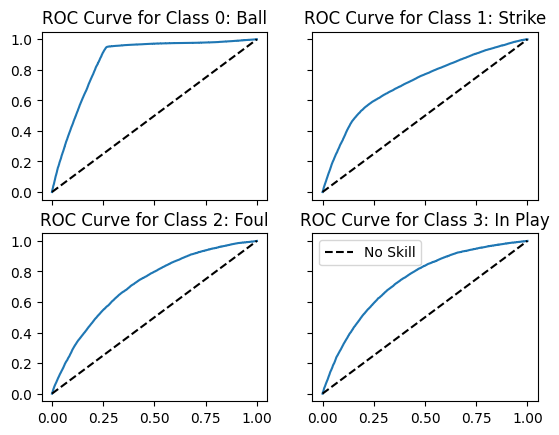

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_pred_probs = model.predict_proba(X_test_abs)

y_test_abs_2 = label_binarize(y_test_abs, classes = [0, 1, 2, 3])

fpr = {}
tpr = {}
roc_auc = {}

for i in range(y_test_abs_2.shape[1]):
  fpr[i], tpr[i], _ = roc_curve(y_test_abs_2[: , i], y_pred_probs[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

fpr['micro'], tpr['micro'], _ = roc_curve(y_test_abs_2.ravel(), y_pred_probs.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

fig, axis = plt.subplots(2,2)
axis[0, 0].plot(fpr[0], tpr[0])
axis[0, 0].plot([0, 1], [0, 1], 'k--', label='No Skill')
axis[0, 0].set_title('ROC Curve for Class 0: Ball')
axis[0, 1].plot(fpr[1], tpr[1])
axis[0, 1].plot([0, 1], [0, 1], 'k--', label='No Skill')
axis[0, 1].set_title('ROC Curve for Class 1: Strike')
axis[1, 0].plot(fpr[2], tpr[2])
axis[1, 0].plot([0, 1], [0, 1], 'k--', label='No Skill')
axis[1, 0].set_title('ROC Curve for Class 2: Foul')
axis[1, 1].plot(fpr[3], tpr[3])
axis[1, 1].plot([0, 1], [0, 1], 'k--', label='No Skill')
axis[1, 1].set_title('ROC Curve for Class 3: In Play')

for ax in axis.flat:
    ax.label_outer()

plt.legend()
plt.show()

## Step 2: Feature Reduction

Let's use a Correlation Matrix to takeout as much multicollinearity we can. Our hope is that this will take out many of the pieces of information that we are already capturing with our model that are only giving us more features without any additional meaningful information.

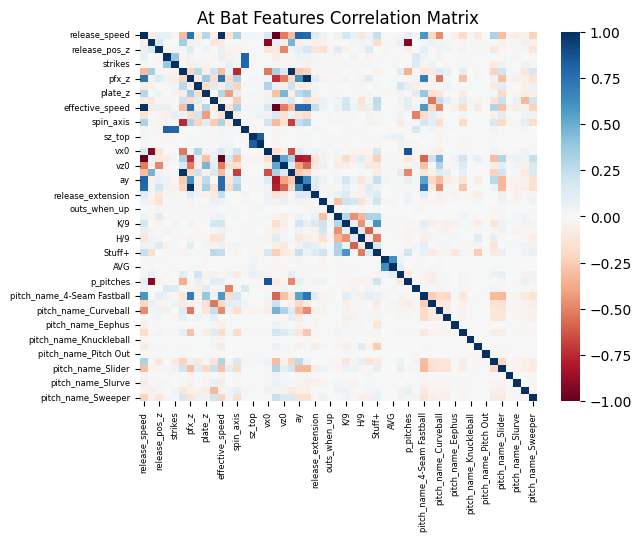

<Figure size 800x800 with 0 Axes>

In [ ]:
corr_mat = encoded_df_abs.corr()
axis = plt.axes()
axis.set_title('At Bat Features Correlation Matrix')
heat = sns.heatmap(corr_mat, vmin=-1, vmax= 1,center= 0, cmap='RdBu', fmt= 'd')

heat.set_xticklabels(heat.get_xmajorticklabels(), fontsize=6)
heat.set_yticklabels(heat.get_ymajorticklabels(), fontsize=6)


s = plt.figure()
s.set_figwidth(8)
s.set_figheight(8)

plt.show()

## Dropping the Most Correlated Features



*   ax, az, ay - captured by vx0 and vz0
*   release_speed, effective_speed - captured by vx0 and vz0
*   Stuff+ - captured by K/9



In [ ]:
encoded_df_abs = encoded_df_abs.drop(['ax', 'az', 'ay', 'release_speed', 'effective_speed', 'Stuff+'], axis=1)

## Rerun Logistic Regression with less Multicolinearity

In [ ]:
# TO-DO: Import required libraries
from sklearn import linear_model

# TO-DO: Initialize model with default parameters and fit it on the training set
model = linear_model.LogisticRegression(max_iter=16000)
model.fit(X_train_abs, y_train_abs)

# TO-DO: Use the model to predict on the test set and save these predictions as `y_pred`
y_pred = model.predict(X_test_abs)

# TO-DO: Find the accuracy and store the value in `log_acc`

log_acc = model.score(X_test_abs, y_test_abs)
print(log_acc)

0.5731359889415215


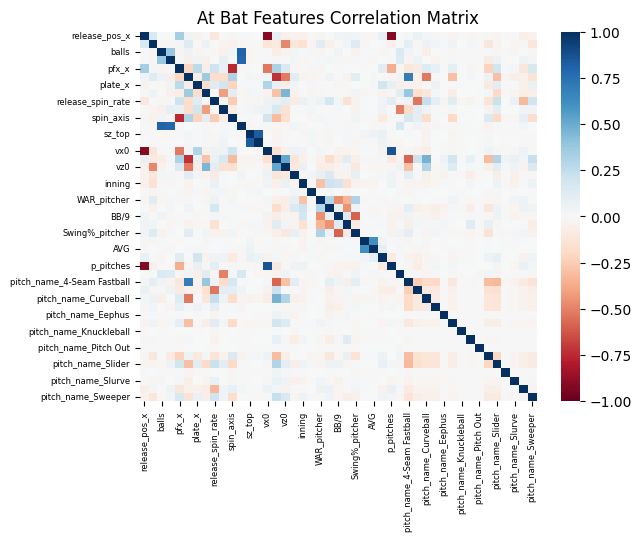

<Figure size 800x800 with 0 Axes>

In [ ]:
corr_mat = encoded_df_abs.corr()
axis = plt.axes()
axis.set_title('At Bat Features Correlation Matrix')
heat = sns.heatmap(corr_mat, vmin=-1, vmax= 1,center= 0, cmap='RdBu', fmt= 'd')

heat.set_xticklabels(heat.get_xmajorticklabels(), fontsize=6)
heat.set_yticklabels(heat.get_ymajorticklabels(), fontsize=6)


s = plt.figure()
s.set_figwidth(8)
s.set_figheight(8)

plt.show()

After removing the listed features the model still produced an accuracy of 0.573. We conclude those features did not meaningfully add any value to the model's predictive power. Let's see if we can further reduce the feature set taking a more systematic approach.

## Try Reducing Additional Multicollinearity using PCA

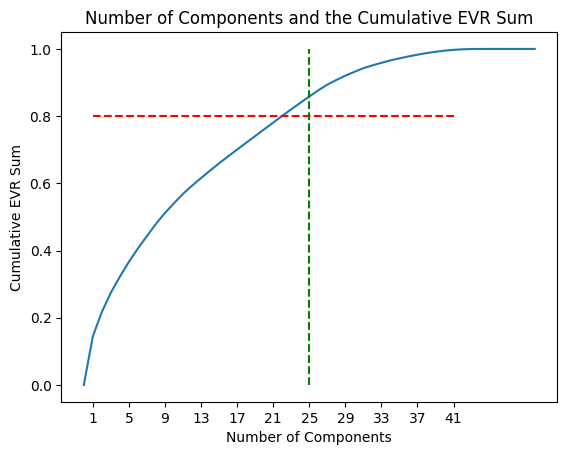

In [ ]:
# TO-DO: Import necessary libraries
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# TO-DO: Intermediate step to address fact that PCA is not scale-invariant
scaler_abs = StandardScaler()
X_train_scaled_abs = scaler_abs.fit_transform(X_train_abs)

# TO-DO: Instantiate and Fit PCA
pca_abs = PCA(n_components=len(features_abs.columns))
X8 = pca_abs.fit_transform(X_train_scaled_abs)

# TO-DO: Save the explained variance ratios into variable called "explained_variance_ratios"
explained_variance_ratio_abs = pca_abs.explained_variance_ratio_

# TO-DO: Save the CUMULATIVE explained variance ratios into variable called "cum_evr"
cum_evr_abs = np.cumsum(explained_variance_ratio_abs)

cel = list(cum_evr_abs)
cel.insert(0, 0)
cum_evr_abs = np.array(cel)

figure, axis = plt.subplots()
axis.plot(cum_evr_abs)
# axis.axhline(y= 0.8, xmin= 1, xmax=3, linestyle='-', color = 'r')

plt.hlines(y=0.8, xmin=1, xmax=41, colors = 'r', linestyle = '--')
plt.vlines(x=[25], ymin=0, ymax=1, colors = ['g', 'y'], linestyle = '--')
# plt.xlim(1, 30)
plt.xticks([1, 5, 9, 13, 17, 21, 25, 29, 33, 37, 41])
plt.xlabel('Number of Components')
plt.ylabel('Cumulative EVR Sum')
plt.title('Number of Components and the Cumulative EVR Sum')
plt.show()

In [ ]:
# TO-DO: Get transformed set of principal components on x_test

# 1. Refit and transform on training with parameter n (as deduced from the last step)
scaler_abs = StandardScaler()
X_train_scaled_abs = scaler_abs.fit_transform(X_train_abs)
pca_abs = PCA(n_components=25)
pca_abs.fit(X_train_scaled_abs)
X9 = pca_abs.transform(X_train_scaled_abs)

# 2. Transform on Testing Set and store it as `X_test_pca
X_test_s_abs = scaler_abs.transform(X_test_abs)

X_test_pca_abs = pca_abs.transform(X_test_s_abs)

# TO-DO: Initialize `log_reg_pca` model with default parameters and fit it on the PCA transformed training set
log_reg_pca = linear_model.LogisticRegression(max_iter=2000).fit(X9, y_train_abs)

# TO-DO: Use the model to predict on the PCA transformed test set and save these predictions as `y_pred`
y_pred = log_reg_pca.predict(X_test_pca_abs)

# TO-DO: Find the accuracy and store the value in `test_accuracy`
test_accuracy = log_reg_pca.score(X_test_pca_abs, y_test_abs)
print(test_accuracy)

0.4966706562600091


### Results:
Reducing multicollinearity using PCA seems to get rid of too much meaningful correlation in our model, performing at only a 49.67% accuracy. Our preformance takes a pretty significant hit when trying to simplify our feature set via PCA.

## Try Reducing Features to Top 17 with Impact on Outcome Column - Pitch Result Label

We have many features, especially after one-hot encoding categorical features. Perhaps our model could benefit from reducing the number of features to only the most impactful to our outcome - 'Pitch Result Label'.

In [ ]:
corr_mat = encoded_df_abs.corr()

print(corr_mat['pitch_result_label'])

release_pos_x                 0.001868
release_pos_z                 0.003055
balls                         0.143860
strikes                       0.135358
pfx_x                        -0.020668
pfx_z                         0.035494
plate_x                      -0.060414
plate_z                       0.110059
release_spin_rate            -0.018362
zone                         -0.506421
spin_axis                     0.023315
pitch_number                  0.167792
sz_top                        0.005397
sz_bot                       -0.018676
vx0                          -0.014717
vy0                          -0.043585
vz0                           0.046072
release_extension            -0.002143
inning                       -0.000804
outs_when_up                 -0.013924
WAR_pitcher                   0.011451
K/9                          -0.027376
BB/9                         -0.042421
H/9                           0.012209
Swing%_pitcher                0.043462
WAR                      

In [ ]:
top17_df = encoded_df_abs[['zone', 'balls', 'strikes', 'plate_z', 'plate_x', 'pitch_number', 'vy0', 'vz0', 'BB/9', 'Swing%_pitcher', 'K/9', 'spin_axis', 'pfx_x', 'pfx_z', 'pitch_name_Curveball', 'pitch_name_Sinker', 'pitch_name_Slider', 'pitch_result_label']]

# Split into features and labels

features_abs = top17_df.drop('pitch_result_label', axis = 1)

target_abs = top17_df['pitch_result_label']


seed = 42
X_train_abs, X_test_abs, y_train_abs, y_test_abs = train_test_split(features_abs, target_abs, test_size= .20, train_size = .80, random_state= seed)


In [ ]:
# TO-DO: Import required libraries
from sklearn import linear_model

# TO-DO: Initialize model with default parameters and fit it on the training set
model = linear_model.LogisticRegression(max_iter=16000)
model.fit(X_train_abs, y_train_abs)

# TO-DO: Use the model to predict on the test set and save these predictions as `y_pred`
y_pred = model.predict(X_test_abs)

# TO-DO: Find the accuracy and store the value in `log_acc`

log_acc = model.score(X_test_abs, y_test_abs)
print(log_acc)

0.5726471232784343


### Results:

Although we see an improvement relative to the PCA reduced feature set, performing at 57.26% instead of 49.67%, we aren't really going anywhere in terms of accuracy down this path. Instead, let us return back to our original feature set and try reducing the outcome set even more to create a more accurate classifier.

## **Step 3: Switching back to Original Features try to Reduce Outcome set to 3**

Here, we use subject matter expertise again to group together similar outcomes. Up until there are two strikes in an at-bat, there is no real meaningful difference between a strike and a foul ball - both count as a strike.

Therefore, let's group together strike and foul outcomes to see if we can create a more accurate model.

### Setup

In [ ]:
df_players_orig = pd.read_csv('/content/drive/My Drive/CIS545_Files/2022 Batting Data/player_at_bat_2022.csv')

In [ ]:
df_abs = df_players_orig[['release_speed', 'release_pos_x', 'release_pos_z', 'description', 'stand', 'p_throws', 'type',
                             'balls', 'strikes', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'release_spin_rate', 'effective_speed', 'pitch_name', 'zone', 'spin_axis',
                             'pitch_number','sz_top', 'sz_bot', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_extension', 'inning', 'outs_when_up', 'on_1b', 'on_2b', 'on_3b']]

In [ ]:
# USED FOR DF_ABS more outcomes
def classify_pitch_result(desc):
  if (desc == 'hit_into_play'):
    return 'in_play'
  elif (desc == 'swinging_strike' or desc == 'swinging_strike_blocked' or desc == 'missed_bunt' or desc == 'called_strike'
        or desc == 'foul' or desc == 'foul_bunt' or desc == 'foul_tip' or desc == 'bunt_foul_tip'):
    return 'strike'
  else:
    return 'ball'

# Classify pitch_results into swing_contact, swing_miss, take_strike, take_ball
df_abs['pitch_result'] = df_abs['description'].apply(lambda x: classify_pitch_result(x))
df_abs['pitch_type'] = df_abs['pitch_name'].apply(lambda x: classify_pitch_type(x))

df_abs['b_hits'] = df_abs['stand'].apply(lambda x: 1 if x == 'R' else 0)
df_abs['p_pitches'] = df_abs['p_throws'].apply(lambda x: 1 if x == 'R' else 0)
df_abs = df_abs.drop(['type', 'description', 'stand', 'p_throws', 'on_1b', 'on_2b', 'on_3b'], axis =1)

df_abs = df_abs.dropna()

# Encode Pitch Name & Convert pitch_result to numbered values
outcome_mapping = {'in_play' : 0, 'strike' : 1, 'ball' : 2}

df_abs['pitch_result_label'] = df_abs['pitch_result'].apply(lambda x: int(outcome_mapping[x]))

df_abs = df_abs.drop('pitch_result', axis=1)

encoded_df_abs = pd.get_dummies(df_abs, columns=['pitch_name'])
# encoded_df_abs = encoded_df_abs.drop(columns=['pitch_name'], axis = 1)
encoded_df_abs = encoded_df_abs.drop(columns=['pitch_type'], axis = 1)          ### LOOK HERE: THIS LINE IS NEW. WITHOUT IT

# OPTIONAL
encoded_df_abs = encoded_df_abs.drop(['release_speed', 'effective_speed', 'ax', 'ay', 'az'], axis=1)


# Split into features and labels
features_abs = encoded_df_abs.drop('pitch_result_label', axis = 1)
target_abs = encoded_df_abs['pitch_result_label']

# Splitting data into trainging and testing sets
seed = 42
X_train_abs, X_test_abs, y_train_abs, y_test_abs = train_test_split(features_abs, target_abs, test_size= .20, train_size = .80, random_state= seed)



<ipython-input-83-768e389a0e57>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_abs['pitch_result'] = df_abs['description'].apply(lambda x: classify_pitch_result(x))
<ipython-input-83-768e389a0e57>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_abs['pitch_type'] = df_abs['pitch_name'].apply(lambda x: classify_pitch_type(x))
<ipython-input-83-768e389a0e57>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

### Logistic Regression Model

In [ ]:
# TO-DO: Import required libraries
from sklearn import linear_model

# TO-DO: Initialize model with default parameters and fit it on the training set
model = linear_model.LogisticRegression(max_iter=16000)
model.fit(X_train_abs, y_train_abs)

# TO-DO: Use the model to predict on the test set and save these predictions as `y_pred`
y_pred = model.predict(X_test_abs)

# TO-DO: Find the accuracy and store the value in `log_acc`

log_acc = model.score(X_test_abs, y_test_abs)
print(log_acc)

0.6736070233269984


### Confusion Matrix

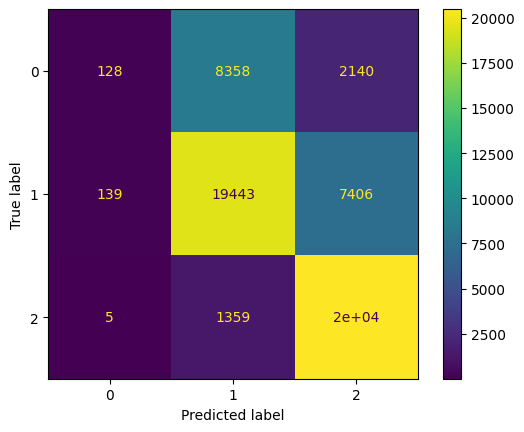

In [ ]:
conf_mat_abs = confusion_matrix(y_true = y_test_abs, y_pred = y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat_abs)
disp.plot()
plt.show()

### Results:

We like the accuracy of our model - 67.36%. However, after reviewing the confusion matrix, it is evident that we have a pretty unbalanced data set. Our model is continuously guessing either ball or strike because it knows that these two outcomes are more common.

To address our balance issue, we will attempt to resample.

## Adjusting label sampling (oversampling/undersampling)

### Initial Setup

In [ ]:
df_players_orig = pd.read_csv('/content/drive/My Drive/CIS545_Files/2022 Batting Data/player_at_bat_2022.csv')

In [ ]:
## we will start with the same model seen above...
df_abs = df_players_orig[['release_speed', 'release_pos_x', 'release_pos_z', 'description', 'stand', 'p_throws', 'type',
                             'balls', 'strikes', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'release_spin_rate', 'effective_speed', 'pitch_name', 'zone', 'spin_axis',
                             'pitch_number','sz_top', 'sz_bot', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_extension', 'inning', 'outs_when_up', 'on_1b', 'on_2b', 'on_3b']]

# USED FOR DF_ABS more outcomes
def classify_pitch_result(desc):
  if (desc == 'hit_into_play'):
    return 'in_play'
  elif (desc == 'swinging_strike' or desc == 'swinging_strike_blocked' or desc == 'missed_bunt' or desc == 'called_strike'
        or desc == 'foul' or desc == 'foul_bunt' or desc == 'foul_tip' or desc == 'bunt_foul_tip'):
    return 'strike'
  else:
    return 'ball'

# USED FOR DF_ABS
def classify_pitch_type(desc):
  if (desc == '4-Seam Fastball' or desc == 'Cutter' or desc == 'Sinker'):
    return 'fastball'
  elif (desc == 'Curveball' or desc == 'Eephus' or desc == 'Knuckle_Curve'or desc == 'Slider' or desc == 'Slow Curve' or desc =='Slurve' or desc == 'Sweeper'):
    return 'breaking_ball'
  elif (desc == 'Changeup'or desc == 'Split-Finger'):
    # if desc == 'called_strike':
    #   return 'strikeout_looking'
    # return 'strikeout_swinging'
    return 'off_speed'
  elif (desc == 'Pitch Out'):
    return 'pitch_out'
  else:
    return 'other'

outcome_mapping = {'in_play' : 0, 'strike' : 1, 'ball' : 2}


################################################################################
######################### handle categorical variables##########################

# Classify pitch_results into swing_contact, swing_miss, take_strike, take_ball
df_abs['pitch_result'] = df_abs['description'].apply(lambda x: classify_pitch_result(x))
df_abs.head(5)
df_abs['b_hits'] = df_abs['stand'].apply(lambda x: 1 if x == 'R' else 0)
df_abs['p_pitches'] = df_abs['p_throws'].apply(lambda x: 1 if x == 'R' else 0)
df_abs = df_abs.drop(['type', 'description', 'stand', 'p_throws', 'on_1b', 'on_2b', 'on_3b'], axis =1)
df_abs = df_abs.dropna()
# Encode Pitch Name & Convert pitch_result to numbered values
outcome_mapping = {'in_play' : 0, 'strike' : 1, 'ball' : 2}
df_abs['pitch_result_label'] = df_abs['pitch_result'].apply(lambda x: int(outcome_mapping[x]))
df_abs = df_abs.drop('pitch_result', axis=1)
encoded_df_abs = pd.get_dummies(df_abs, columns=['pitch_name'])
# encoded_df_abs = encoded_df_abs.drop(columns=['pitch_name'], axis = 1)
# OPTIONAL
encoded_df_abs = encoded_df_abs.drop(['release_speed', 'effective_speed', 'ax', 'ay', 'az'], axis=1)

### Setting up Over and Under Sample Testing

In [ ]:
## this is the original label distribution.
encoded_df_abs[['pitch_result_label', 'p_pitches']].groupby('pitch_result_label', as_index=False).count().rename(columns={'p_pitches':'count'})

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

features_abs = encoded_df_abs.drop('pitch_result_label', axis=1)
target_abs = encoded_df_abs['pitch_result_label']
seed = 42


ros = RandomOverSampler()
x_ros, y_ros = ros.fit_resample(features_abs, target_abs,)
up_X_train_abs, up_X_test_abs, up_y_train_abs, up_y_test_abs = train_test_split(x_ros, y_ros, test_size= .20, train_size = .80, random_state= seed)

rus = RandomUnderSampler()
x_rus, y_rus = rus.fit_resample(features_abs, target_abs)
down_X_train_abs, down_X_test_abs, down_y_train_abs, down_y_test_abs = train_test_split(x_rus, y_rus, test_size= .20, train_size = .80, random_state= seed)

### Model Execution and Results



In [ ]:
################################################################################
######################### Model for down sampling ##############################
# TO-DO: Import required libraries
from sklearn import linear_model

# TO-DO: Initialize model with default parameters and fit it on the training set
down_model = linear_model.LogisticRegression(max_iter=16000)
down_model.fit(down_X_train_abs, down_y_train_abs)

# TO-DO: Use the model to predict on the test set and save these predictions as `y_pred`
down_y_pred = down_model.predict(down_X_test_abs)

# TO-DO: Find the accuracy and store the value in `log_acc`

log_acc = down_model.score(down_X_test_abs, down_y_test_abs)
print('down sampling accuracy results: %s' % (log_acc))


################################################################################
######################### Model for up sampling ################################
# TO-DO: Import required libraries
from sklearn import linear_model

# TO-DO: Initialize model with default parameters and fit it on the training set
up_model = linear_model.LogisticRegression(max_iter=16000)
up_model.fit(up_X_train_abs, up_y_train_abs)

# TO-DO: Use the model to predict on the test set and save these predictions as `y_pred`
up_y_pred = up_model.predict(up_X_test_abs)

# TO-DO: Find the accuracy and store the value in `log_acc`

log_acc = up_model.score(up_X_test_abs, up_y_test_abs)
print('up sampling accuracy results: %s' % (log_acc))

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_mat_abs = confusion_matrix(y_true = down_y_test_abs, y_pred = down_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat_abs)
disp.plot()
plt.title('Down Sampling Confusion Matrix')
plt.show()

print()
conf_mat_abs = confusion_matrix(y_true = up_y_test_abs, y_pred = up_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat_abs)
disp.plot()
plt.title('Up Sampling Confusion Matrix')
plt.show()


### Conclusion

So far, we have seen that using 3 labels and using only the original dataset  has produced the best results.

In the initial data exploration, we noticed a skew in the freq of labels. This leads us to test if normalizing the freq of labels will increase logistic regression performance.

The data will be pre-processed in the following way:
<ul>
  <li>All Categorical variables will be one-hot encoded</li>
</ul>

A dataset with 25 post-PCA components will be tested as well as the full data set against under sampling to the lowest frequency and over sampled to match the label with the highest frequency.



<b>Results</b>

The results (accuracy) are as follows:
<ul>
  <li>Down Sampling accuracy: 0.6127</li>
  <li>Up Sampling accuracy: 0.6108</li>
</ul>


<b>Conclusion</b>
In both cases, the results are not better. To get an understanding of how sample size changes performance, it is best to analyze the appropariate sample size by building a learning curve for logisitic regression model.

##Tuning Hyperparameters for Logistic Regression Model: Learning Curve

We see that over sampling and undersamping may not play a big role in this data set. However, let's take a look at the effect of sample size on the learning process for our model. We want to confirm that our model is continuing to learn with each as the data set grows.

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(estimator= model, X=X_train_abs, y= y_train_abs,
                                                        train_sizes= [0.1, 0.3, 0.5, 0.6, 0.7, 0.8], cv= 6,
                                                        n_jobs=1)

print(train_scores)

[[0.66905495 0.66839901 0.66839901 0.66839901 0.66839901 0.66839901]
 [0.66742911 0.66912779 0.66946416 0.66946416 0.66946416 0.66946416]
 [0.66728559 0.66817361 0.66891026 0.66848643 0.66848643 0.66848643]
 [0.66723849 0.66802896 0.66866806 0.66807101 0.6677935  0.6677935 ]
 [0.6679665  0.66774305 0.66849988 0.66872333 0.66757727 0.66757727]
 [0.66814879 0.6684326  0.66876056 0.66893085 0.66811095 0.66792805]]


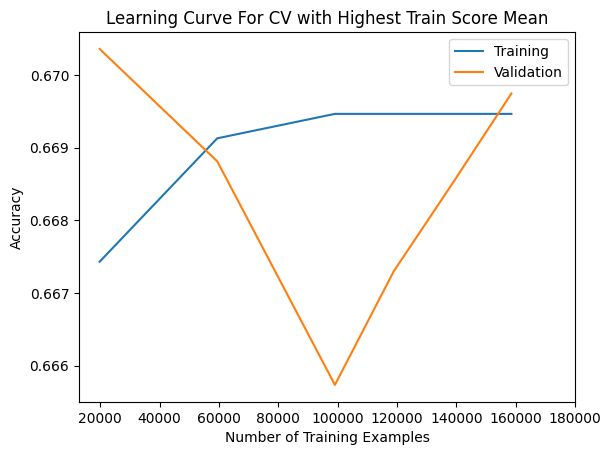

In [ ]:
train = plt.plot(train_sizes, train_scores[1])
validate = plt.plot(train_sizes, test_scores[1])

plt.legend(labels=['Training', 'Validation'])
plt.xlim(right=180000)
plt.xlabel("Number of Training Examples")
plt.ylabel("Accuracy")
plt.title('Learning Curve For CV with Highest Train Score Mean')
plt.show()

### Result:

We want a Training Example count to be right before the Training and Validation accuracies meet. That is right around the interval between 140,000 and 160,000. This would be approximately 80-90% of our training data, which is already the proportion of our data that we have allotted to training.

For full disclosure, we also attempted to create a validation curve for the Logistic Regression model, but found that it took significantly longer to run. So long in fact, that it never actually finished running before our Google Colab session would disconnect.

Because of this, it seems that we are limited in how we can tune the hyperparameters for Logistic Regression. We will now try more sophisticated models to see if it positively impacts performance.

## ADA Boost Classifier

We wanted to try using ensemble classification methods to better our model. An ADA Boost Classifier was particularly attractive because of how it uses sequential trees to learn from mistakes made by others earlier on in the process.

Not shown here, we also experimented with a Random Forest Classifier, but found that it did not improve the accuracy of the model. We think that the Random Forest Classifiers that we did attempt likely overfit to our training data, which ended up hurting test performance.

Again, trying to tune the hyperparameters for AdaBoostClassifier took too long. Instead we manually adjusted both the depth of trees from 1 to 4 and the number of estimators used from 500 to 1,000 to see which configuration allowed the model to perform best.

The best performing model is below, which made made accurate predictions at a 71% rate.

In [ ]:
df_abs = df_players_orig[['release_speed', 'release_pos_x', 'release_pos_z', 'description', 'stand', 'p_throws', 'type',
                             'balls', 'strikes', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'release_spin_rate', 'effective_speed', 'pitch_name', 'zone', 'spin_axis',
                             'pitch_number','sz_top', 'sz_bot', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_extension', 'inning', 'outs_when_up', 'on_1b', 'on_2b', 'on_3b']]

In [ ]:
# USED FOR DF_ABS more outcomes
def classify_pitch_result(desc):
  if (desc == 'hit_into_play'):
    return 'in_play'
  elif (desc == 'swinging_strike' or desc == 'swinging_strike_blocked' or desc == 'missed_bunt' or desc == 'called_strike'
        or desc == 'foul' or desc == 'foul_bunt' or desc == 'foul_tip' or desc == 'bunt_foul_tip'):
    return 'strike'
  else:
    return 'ball'

# Classify pitch_results into swing_contact, swing_miss, take_strike, take_ball
df_abs['pitch_result'] = df_abs['description'].apply(lambda x: classify_pitch_result(x))

df_abs.head(5)

df_abs['b_hits'] = df_abs['stand'].apply(lambda x: 1 if x == 'R' else 0)
df_abs['p_pitches'] = df_abs['p_throws'].apply(lambda x: 1 if x == 'R' else 0)
df_abs = df_abs.drop(['type', 'description', 'stand', 'p_throws', 'on_1b', 'on_2b', 'on_3b'], axis =1)

df_abs = df_abs.dropna()

# Encode Pitch Name & Convert pitch_result to numbered values


outcome_mapping = {'in_play' : 0, 'strike' : 1, 'ball' : 2}

df_abs['pitch_result_label'] = df_abs['pitch_result'].apply(lambda x: int(outcome_mapping[x]))

df_abs = df_abs.drop('pitch_result', axis=1)

encoded_df_abs = pd.get_dummies(df_abs, columns=['pitch_name'])
# encoded_df_abs = encoded_df_abs.drop(columns=['pitch_name'], axis = 1)

# OPTIONAL
encoded_df_abs = encoded_df_abs.drop(['release_speed', 'effective_speed', 'ax', 'ay', 'az'], axis=1)


# Split into features and labels

features_abs = encoded_df_abs.drop('pitch_result_label', axis = 1)

target_abs = encoded_df_abs['pitch_result_label']

# target.head(10)

seed = 42
X_train_abs, X_test_abs, y_train_abs, y_test_abs = train_test_split(features_abs, target_abs, test_size= .20, train_size = .80, random_state= seed)

<ipython-input-117-b405c906f615>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_abs['pitch_result'] = df_abs['description'].apply(lambda x: classify_pitch_result(x))
<ipython-input-117-b405c906f615>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_abs['b_hits'] = df_abs['stand'].apply(lambda x: 1 if x == 'R' else 0)
<ipython-input-117-b405c906f615>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

0.7102709430027414


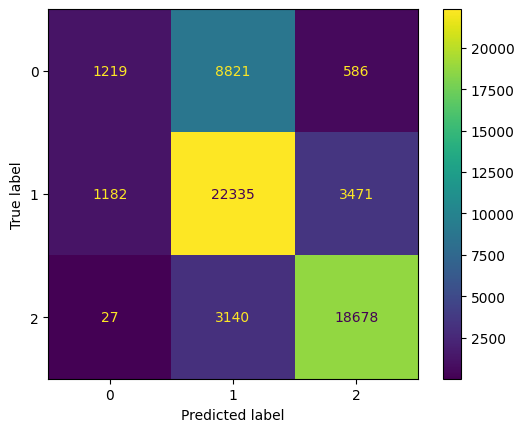

In [ ]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=0)

ada = AdaBoostClassifier(estimator=tree, n_estimators=700, learning_rate=0.1, random_state=0)

ada.fit(X_train_abs, y_train_abs)

y_pred = ada.predict(X_test_abs)

ada_acc = ada.score(X_test_abs, y_test_abs)
print(ada_acc)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_mat_abs = confusion_matrix(y_true = y_test_abs, y_pred = y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat_abs)
disp.plot()
plt.show()

## Results:

We see here that the Ada Boost classifier is doing a better job at predicting all classes than did our Logistic Regression model. Like the Logistic Regression Model it does a much better job distinguishing between balls and strikes, and balls and in_play than it does strikes and in_play.

Let's review the area under the ROC curve for each of the classes to get a better sense on the model's ability to predict the classes accurately.

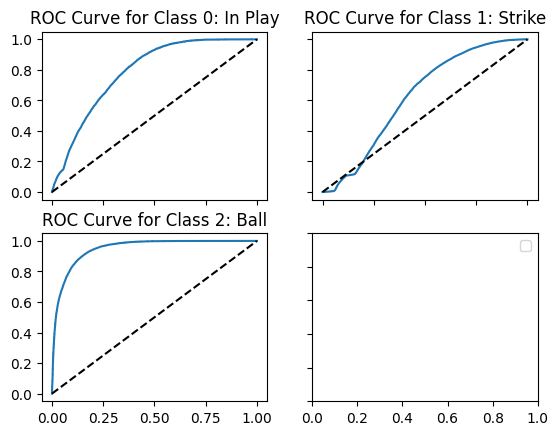

{0: 0.785466106615205, 1: 0.6280027300939603, 2: 0.9477794526840283, 'micro': 0.8190120982325936}


In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_pred_probs = ada.predict_proba(X_test_abs)

y_test_abs_2 = label_binarize(y_test_abs, classes = [0, 1, 2])

fpr = {}
tpr = {}
roc_auc = {}

for i in range(y_test_abs_2.shape[1]):
  fpr[i], tpr[i], _ = roc_curve(y_test_abs_2[: , i], y_pred_probs[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

fpr['micro'], tpr['micro'], _ = roc_curve(y_test_abs_2.ravel(), y_pred_probs.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

fig, axis = plt.subplots(2,2)
axis[0, 0].plot(fpr[0], tpr[0])
axis[0, 0].plot([0, 1], [0, 1], 'k--', label='No Skill')
axis[0, 0].set_title('ROC Curve for Class 0: In Play')
axis[0, 1].plot(fpr[1], tpr[1])
axis[0, 1].plot([0, 1], [0, 1], 'k--', label='No Skill')
axis[0, 1].set_title('ROC Curve for Class 1: Strike')
axis[1, 0].plot(fpr[2], tpr[2])
axis[1, 0].plot([0, 1], [0, 1], 'k--', label='No Skill')
axis[1, 0].set_title('ROC Curve for Class 2: Ball')
# axis[1, 1].plot(fpr[3], tpr[3])
# axis[1, 1].plot([0, 1], [0, 1], 'k--', label='No Skill')
# axis[1, 1].set_title('ROC Curve for Class 3: In Play')

for ax in axis.flat:
    ax.label_outer()

plt.legend()
plt.show()


print(roc_auc)

# Results:

Our Ada Boost Classifier model performs the best at 71% accuracy compared to any of our other models we attempted. As you can see in the above diagram that the model pretty effectively is able to predict balls and strikes. With low thresholds, it has a much tougher time predicting the strike class accurately, which is likely due to the fact that strikes are swung at much more than balls are by batters. Overall, we are encourage at the AUC micro-average of 81.9%.

Even though this combination of hyperparameters had the best test accuracy, our Ada Boost Classifier with a depth of 2 actually had better ROC curves - with a micro average of around 0.84.

## **TRY FNN to improve Performance**

Finally, although we were able to find a model that would make accurate predictions greater than 70%, we want to see if we can create an FNN that would be more accurate than our Ada Boost Classifier.

### Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from collections import Counter
from PIL import Image
from skimage import io, transform
import os
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from google.colab import drive

In [ ]:
# DO NOT MODIFY
torch.manual_seed(42) # For grading consistency
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)

2.3.1+cu121
cpu


In [ ]:
device

device(type='cpu')

## Cleaning Data for FNN

In [ ]:
df_players_orig = pd.read_csv('/content/drive/My Drive/CIS545_Files/2022 Batting Data/player_at_bat_2022.csv')
df_abs = df_players_orig[['release_speed', 'release_pos_x', 'release_pos_z', 'description', 'stand', 'p_throws', 'type',
                             'balls', 'strikes', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'release_spin_rate', 'effective_speed', 'pitch_name', 'zone', 'spin_axis',
                             'pitch_number','sz_top', 'sz_bot', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_extension', 'inning', 'outs_when_up', 'on_1b', 'on_2b', 'on_3b']]


# USED FOR DF_ABS more outcomes
def classify_pitch_result(desc):
  if (desc == 'hit_into_play'):
    return 'in_play'
  elif (desc == 'swinging_strike' or desc == 'swinging_strike_blocked' or desc == 'missed_bunt' or desc == 'called_strike'
        or desc == 'foul' or desc == 'foul_bunt' or desc == 'foul_tip' or desc == 'bunt_foul_tip'):
    return 'strike'
  else:
    return 'ball'

# Classify pitch_results into in_play, strike, and ball
df_abs['pitch_result'] = df_abs['description'].apply(lambda x: classify_pitch_result(x))

df_abs['b_hits'] = df_abs['stand'].apply(lambda x: 1 if x == 'R' else 0)
df_abs['p_pitches'] = df_abs['p_throws'].apply(lambda x: 1 if x == 'R' else 0)
df_abs = df_abs.drop(['type', 'description', 'stand', 'p_throws', 'on_1b', 'on_2b', 'on_3b'], axis =1)

df_abs = df_abs.dropna()

# Encode Pitch Name & Convert pitch_result to numbered values
outcome_mapping = {'in_play' : 0, 'strike' : 1, 'ball' : 2}
df_abs['pitch_result_label'] = df_abs['pitch_result'].apply(lambda x: int(outcome_mapping[x]))
df_abs = df_abs.drop('pitch_result', axis=1)
encoded_df_abs = pd.get_dummies(df_abs, columns=['pitch_name'])

# OPTIONAL
encoded_df_abs = encoded_df_abs.drop(['release_speed', 'effective_speed', 'ax', 'ay', 'az'], axis=1)


# Split into features and labels
features_abs = encoded_df_abs.drop('pitch_result_label', axis = 1)
target_abs = encoded_df_abs['pitch_result_label']


seed = 42
X_train_abs, X_test_abs, y_train_abs, y_test_abs = train_test_split(features_abs, target_abs, test_size= .20, train_size = .80, random_state= seed)

<ipython-input-63-9313a090573d>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_abs['pitch_result'] = df_abs['description'].apply(lambda x: classify_pitch_result(x))
<ipython-input-63-9313a090573d>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_abs['b_hits'] = df_abs['stand'].apply(lambda x: 1 if x == 'R' else 0)
<ipython-input-63-9313a090573d>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

### Comparing testing and training Label Frequency

In [ ]:
# setting up for training label plot
# Creating dictionary for train dataset
train_subset_dict = {}
train_labels = np.array(y_train_abs)
for i in range(len(train_labels)):
  label = train_labels[i]
  if label not in train_subset_dict.keys():
    train_subset_dict[label] = 1
  else:
    train_subset_dict[label] += 1

train_labels = [label for label in train_subset_dict.keys()]
train_values = [train_subset_dict[train_labels[i]] for i in train_labels]

In [ ]:
# setting up for testing label plot
test_subset_dict = {}
test_labels = np.array(y_test_abs)
for i in range(len(test_labels)):
  label = test_labels[i]
  if label not in test_subset_dict.keys():
    test_subset_dict[label] = 1
  else:
    test_subset_dict[label] += 1

test_labels = [label for label in test_subset_dict.keys()]
test_values = [test_subset_dict[test_labels[i]] for i in test_labels]

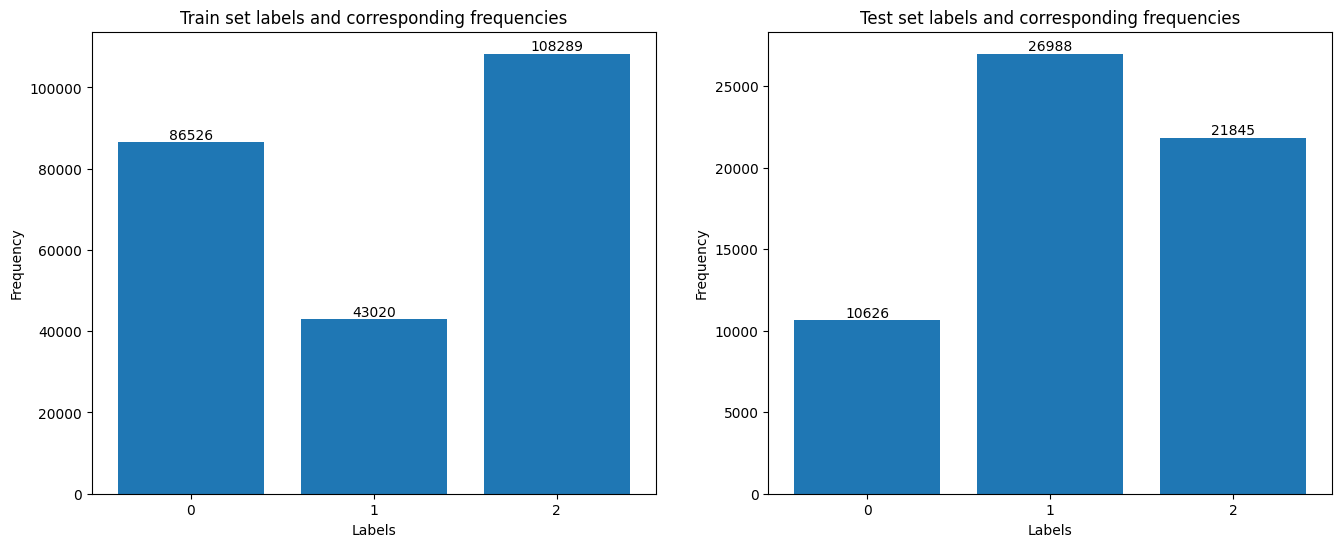

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(16,6))

r0 = axis[0].bar(train_labels, train_values, label=train_values, align='center')
axis[0].bar_label(r0, label_type='edge')
axis[0].set_xticks(train_labels)
axis[0].set_xlabel("Labels")
axis[0].set_ylabel("Frequency")
axis[0].set_title("Train set labels and corresponding frequencies")

r1 = axis[1].bar(test_labels, test_values, label= test_values, align='center')
axis[1].bar_label(r1, label_type='edge')
axis[1].set_xticks(test_labels)
axis[1].set_xlabel("Labels")
axis[1].set_ylabel("Frequency")
axis[1].set_title("Test set labels and corresponding frequencies")
plt.show()

## Results:

From the bar graphs above, it is evident that our data is unbalanced. We have roughly 60,000 more instances of class 2 than class 1 and we have roughly 30,000 more instances of class 0 than 1.

In order to balance the data set better, let's try upsampling the set.

### Adjusting sample frequncy by upsampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# over sampling to balance out data set
ros = RandomOverSampler()
x_rus, y_rus = ros.fit_resample(features_abs, target_abs)
up_X_train_abs, up_X_test_abs, up_y_train_abs, up_y_test_abs = train_test_split(x_rus, y_rus, test_size= .20, train_size = .80, random_state= seed)

In [ ]:
# setting up for training label plot
# Creating dictionary for train dataset
train_subset_dict = {}
train_labels = np.array(up_y_train_abs)
for i in range(len(train_labels)):
  label = train_labels[i]
  if label not in train_subset_dict.keys():
    train_subset_dict[label] = 1
  else:
    train_subset_dict[label] += 1

train_labels = [label for label in train_subset_dict.keys()]
train_values = [train_subset_dict[train_labels[i]] for i in train_labels]

# setting up for testing label plot
test_subset_dict = {}
test_labels = np.array(up_y_test_abs)
for i in range(len(test_labels)):
  label = test_labels[i]
  if label not in test_subset_dict.keys():
    test_subset_dict[label] = 1
  else:
    test_subset_dict[label] += 1

test_labels = [label for label in test_subset_dict.keys()]
test_values = [test_subset_dict[test_labels[i]] for i in test_labels]

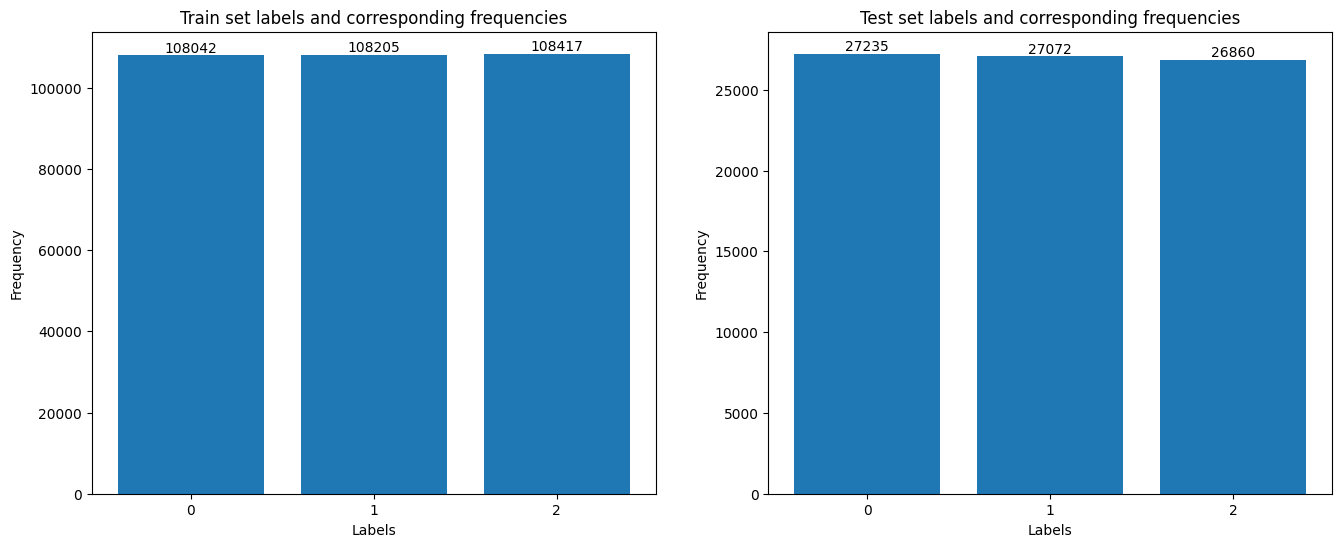

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(16,6))

r0 = axis[0].bar(train_labels, train_values, label=train_values, align='center')
axis[0].bar_label(r0, label_type='edge')
axis[0].set_xticks(train_labels)
axis[0].set_xlabel("Labels")
axis[0].set_ylabel("Frequency")
axis[0].set_title("Train set labels and corresponding frequencies")

r1 = axis[1].bar(test_labels, test_values, label= test_values, align='center')
axis[1].bar_label(r1, label_type='edge')
axis[1].set_xticks(test_labels)
axis[1].set_xlabel("Labels")
axis[1].set_ylabel("Frequency")
axis[1].set_title("Test set labels and corresponding frequencies")
plt.show()

## Result:

After upsampling we have a much more balanced data set. We have roughly even numbers of instances for our classes. As a result, the results of our testing should better represent the quality of our model.

### Setting up and Training the Model

In [ ]:
# Read data, convert to NumPy arrays
up_X_train_array = np.array(up_X_train_abs).astype(float)
up_y_train_array = np.array(up_y_train_abs).astype(float)

up_X_train_array = np.array(up_X_test_abs).astype(float)
up_y_train_array = np.array(up_y_test_abs).astype(float)

# convert into PyTorch tensors
X_train = torch.tensor(up_X_train_array, dtype=torch.float32)
y_train = torch.tensor(up_y_train_array, dtype=torch.float32)

X_test = torch.tensor(up_X_train_array, dtype=torch.float32)
y_test = torch.tensor(up_y_train_array, dtype=torch.float32)


# set up DataLoader for training set
train_loader = DataLoader(list(zip(X_train, y_train)), shuffle=True, batch_size=16)
test_loader = DataLoader(list(zip(X_test, y_test)), batch_size= 16, shuffle= True, num_workers= 0)

## Creating the FNN Model

We experimented with a number of different layers, in addition to number of inputs and outputs for each linear layer we had. As was mentioned in lecture, we found this process to be as much of an art as a science.

After different configurations of one to six hidden layers, different combinations of activation functions (ReLU, Sigmoid and Softmax), and different input / output combinations for each of the linear layers (37 -> 24 -> 12 -> 3, 37 -> 16 -> 3, 37 -> 12 -> 3, etc) we found that inserting hidden layers where the size of the layer didn't change helped the performance of the model. We think this could be due to  the extraction of additional meaning from the feature set without losing information by reducing the number of outputs in the previous layer.

In [ ]:
class FNN(nn.Module):
    def __init__(self):
        super().__init__()
        # self.flatten = nn.Flatten(start_dim=1)
        self.hidden = nn.Linear(37, 37)
        self.hidden2 = nn.Linear(37, 37)
        self.hidden3 = nn.Linear(37, 12)
        # self.hidden4 = nn.Linear(24, 24)
        # self.hidden5 = nn.Linear(24, 12)
        self.hidden6 = nn.Linear(12, 12)
        self.output = nn.Linear(12, 3)
        self.soft = nn.Softmax(dim=1)
        self.sig = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        outputs = nn.Sequential(self.hidden, self.relu, self.hidden2, self.relu, self.hidden3, self.relu, self.hidden6, self.relu,self.output, self.soft)(x)
        # END TODO
        return outputs

In [ ]:
%%time
# Sending the data to device (CPU or GPU)
fnn = FNN().to(device)
# Step 2: set the loss criterion as CrossEntropyLoss
criterion = nn.CrossEntropyLoss()
# END TODO
optimizer = optim.Adam(fnn.parameters(), lr=.00011) #lr - learning step
epoch = 10

acc_LIST_FNN = []
loss_LIST_FNN = []

# Train the FNN
for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
      # print(inputs, labels)
      labels = labels.type(torch.LongTensor) # Cast to Long
      inputs, labels = inputs.to(device), labels.to(device)
      # print(fnn.hidden.weight.dtype)
      ## TODO (2 of 2)
      # Step 1: Reset the optimizer tensor gradient every mini-batch
      optimizer.zero_grad()
      # Step 2: Feed the network the train data
      fnn_output = fnn(inputs)
      # print('who?')
      # Step 3: Get the prediction using argmax
      fnn_prediction = torch.argmax(fnn_output, axis=1)
      # Step 4: Find average loss for one mini-batch of inputs
      loss = criterion(fnn_output, labels)
      # Step 5: Do a back propagation
      loss.backward()
      # Step 6: Update the weight using the gradients from back propagation by learning step
      optimizer.step()

      # Step 7: Get loss and add to accumulated loss for each epoch
      running_loss += loss.item()

      # Step 8: Get number of correct prediction and increment the number of correct and total predictions after this batch
      # Hint: we need to detach the numbers from GPU to CPU, which stores accuracy and loss
      predictions = fnn_prediction.detach()
      labels2 = labels.detach()
      correct += (predictions == labels2).sum().item()
      # print(correct)
      total += labels2.shape[0]

  # Step 9: Calculate training accuracy for each epoch (should multiply by 100 to get percentage), store in variable called 'accuracy', and add to acc_LIST_FNN
  accuracy = (correct/total)*100
  acc_LIST_FNN.append(accuracy)
  # Step 10: Get average loss for each epoch and add to loss_LIST_FNN
  loss_LIST_FNN.append(running_loss/total)

  # END TODO

  # print statistics
  print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss/len(X_train), accuracy))

The loss for Epoch 0 is: 0.06681118204960038, Accuracy = 42.957113112471816
The loss for Epoch 1 is: 0.06125748295705098, Accuracy = 54.66753729964148
The loss for Epoch 2 is: 0.05939029930629775, Accuracy = 56.82481796789336
The loss for Epoch 3 is: 0.05886542101075683, Accuracy = 57.35089383616494
The loss for Epoch 4 is: 0.05867151348506284, Accuracy = 57.916394593862044
The loss for Epoch 5 is: 0.05858855395717913, Accuracy = 58.032205206549456
The loss for Epoch 6 is: 0.058431604681893054, Accuracy = 58.564441213793785
The loss for Epoch 7 is: 0.058368266313224976, Accuracy = 58.948833885692466
The loss for Epoch 8 is: 0.058262637557960135, Accuracy = 59.21495188931463
The loss for Epoch 9 is: 0.05817916443523968, Accuracy = 59.535279115896856
CPU times: user 2min 30s, sys: 1.43 s, total: 2min 32s
Wall time: 2min 47s


### Assessing Training over Epochs

Let's assess if we have enough data to train our model. From the results we see the model's performance over the later training Epochs levels out around 59% on the balanced dataset. This was significantly worse than the performance of the same FNN on the unbalanced dataset, which hovered around 66%.

We'll plot the performance on the training set to get a better sense of the trend:

<Figure size 500x480 with 0 Axes>

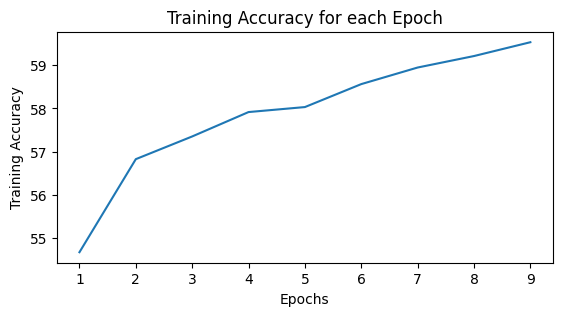

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# TODO
epochs = [i for i in range(epoch+1)]
accuracies = acc_LIST_FNN

plt.figure().set_figwidth(5)
plt.figure().set_figheight(3)
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy for each Epoch")
plt.plot(epochs[1:], accuracies[1:])
# END TODO


## Results

We see that the performance of the model on the training set continued to improve as the number of epochs grew. This could be an indication that the model could benefit from even more training data.

Let's see what kind of effect the continuous increase of performance had on the accuracy on the test set.

In [ ]:
total = 0
correct = 0
pred_list = []
labels_list = []
with torch.no_grad():
    for inputs, labels in test_loader:
        labels = labels.type(torch.LongTensor) # Cast to Float
        inputs, labels = inputs.to(device), labels.to(device)

        # TODO
        # Get the output
        fnn_outputs = fnn(inputs)
        # Get the prediction using argmax
        fnn_predict = torch.argmax(fnn_outputs, axis= 1)
        # Get number of correct prediction and add to correct and total
        predict = fnn_predict.detach()
        pred_list.extend(predict.tolist())
        labels = labels.detach()
        labels_list.extend(labels.tolist())
        correct += (fnn_predict == labels).sum()
        total += labels.shape[0]

# Calculate test accuracy for FNN (should multiple by 100)
test_acc_FNN = 100 * ((correct) / len(y_test))
# TODO END
print('Test Accuracy: ' + str(test_acc_FNN.item()))

Test Accuracy: 60.86094284057617


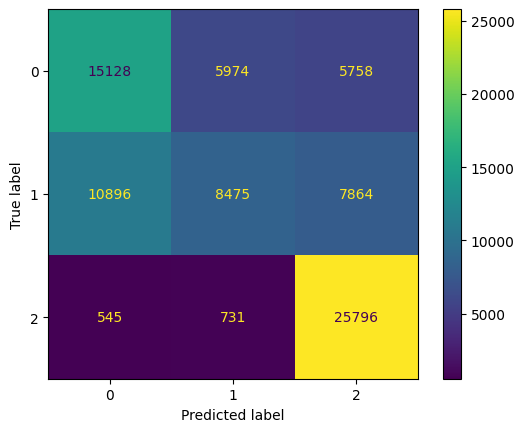

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_mat_abs = confusion_matrix(y_true = labels_list, y_pred = pred_list)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat_abs)
disp.plot()
plt.show()

## Results:

The results of the test are pretty promising. With continuous improvements on accuracy during training, we were concerned with the possibility that we could be overfitting the dataset. However, since the performance on test was better than it had been during training, the result indicates that we likely could benefit from more training.

Additionally, as you can see in the Confusion Matrix above, due to the upsampling performed above our model's predictions in test are fairly well distributed across each of the classes.

As is evident in the model, we have a very difficult time distinguishing between a pitch that will be batted in play and a pitch that is a strike. Intuitively, this makes sense. An overwhelming majority of balls that are swung at are within the strikezone.



# **Conclusion**

From the outset of the project we wanted to try to answer an interesting question. One that we had not seen answered in other data science projects - can we predict the outcome of a pitch using pitch specific data only?

We think we have shown that to some extent it is possible to predict pitch outcomes based on pitch features. As an overview, the project can be broken down into multiple sections: initial approach where we cleaned the data and tried a simple model without much data modification, data and model tuning where we used unsupervised learning, PCA, sample balancing to try and improve perforamnce, and finally complex model approaches where we try to tune a Ada Boost Classifier and FNN model to see if we can get better results.

<br/>

We began the project using subject matter knowledge to reduce pitch features to around 30 that we believed to be most impactful. After creating an initial feature set, we then used best practices to clean the data. We removed data with null values wherever possible, and encoded categorical data using both one-hot encoding and mapping to integer values.

Following the feature and label creation, we ran baseline tests to get an idea of how accurate a random guessing model would be at predicting outcomes in addition to a Logistic Regression Model. We found these both to perform exceptionally poorly - 21% and 34% respectively. To improve performance, we reasoned that it would be easier to classify fewer outcomes. We took an unsupervised learning approach, k-Means clustering, to help us find the number of appropriate outcome classes.

<br/>

This brings us into feature and outcome set tuning. Using k-Means clustering algorithm to generate an elbow chart, we determined that 4 or 5 clusters was the likely optimal outcome set size. We then used subject matter knowledge to group similar outcomes into 4 categories - in_play, strike, ball, and foul. We then tried a number of different models and configurations with this outcome set.

Then we turned our focus to the feature set. First we manually tested a reduced feature set by looking to remove features that have little to no coorelation with the outcome set via manual analysis of a coorelation matrix. To take a more systematic approach we next applied PCA to. We retried Logistic Regression with and without a reduced feature set having PCA applied. Neither of these however let our model get to an accuracy above 57%.

After continuously tweaking the feature set, we finally resolved to return to the original feature set and reduce the outcomes from 4 to 3, lumping together strike and foul. We did this because foul balls are counted as strikes until a player has 2 strikes in an at-bat. We figured if a foul is a strike most of the time, perhaps our model is justifiably having difficulty in distinguishing the two.

After reducing the outcome set even more, we finally found improvements in our model's accuracy. Using Logistic Regression we jumped to a 67% accuracy. Trying to improve even more, we tried reviewing the learning curve of the Logic Regression Model, which didn't bring us any new insights on how to better the model. Additionally, we found that even though the Logistic Regression's accuracy was higher than the rest we had tried, our model suffered from being imbalanced. Essentially, the performance during test time had inflated due to repeatedly guessing class 1 and 2, leaving the false negative count really high for pitches in the 0 class. In other words, the precision and recall measures for each of our classes were not very good.

In order to correct the inbalanced data set, we attempted both upsampling and downsampling, which both worked, but caused the model unsurprisingly to be less accurate - predicting at around a 60% clip.

<br/>

Not satisfied with the result of the perfomrance, we continued to try more complex models, both an ensemble model and a FNN. The ensemble model of choice was an Ada Boost Classifer. After getting nowhere with a Random Forest Classifer - we think due to overfitting the training set - we thought the Ada Boost Classifer would benefit us due to its sequential learning. Because it allows for many different stumps to correct the mistakes of previous stumps, without having deep decision tress to overfit the data, we thought using an Ada Boost Classifier was a good approach.

Ultimately, we found the most success with the Ada Boost Classifier, which performed on the unbalanced data set with an accuracy of 71%. We even found after reviewing the confusion matrix for the model that it even predicted the 0 class significantly more than the Logistic Regression model had previously. Additionally, reviewing ROC Curves for how well the model was able to predict outcomes, we found that this model had the highest micro-average for Area Under the Curve out of any model we test, which was 81%.

Lastly, we wanted to see if we could make one last attempt to improve our accuracy by using a feedforward neural network. After a number of different configurations, we found that this FNN too was barely predicting pitches to be in the 0 class, so we had to rebalance our data. After doing so, our model's performance dimished from 67% to 60% - again doing a particularly bad job at distinguishing between pitches hit in play and pitches that resulted in strikes.

<br/>

We think that if we had more time, we would have liked to spend more time on hyperparameter tuning. After trying several times for our models, with programs running for 10 to 12 hours in some cases, we found it to be infeasible for how many different models, feature sets and outcome classes we wanted to try.

Even though our models were able to makes sense of some of the randomness that is baseball, I think our efforts here highlight the some of the intricacies that cause people to adore baseball - how frequently fans see things they claim to have never seen before and how difficult it can be at times to predict outcomes in the sport.